# 0. Import Dependencies of the Project

In [1]:
#Import Python Libraries
import pandas as pd
import pickle
import time
import numpy as np

#Import Self-written Functions
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

from d00_utils.calculateTimeDifference import calculateTimeDifference #Function to calc time difference
from d01_data.loadCommits import loadCommits #Function to load SVN data
from d02_intermediate.cleanCommitData import cleanCommitData #Function to clean commit data
from d02_intermediate.cleanJiraData import cleanJiraData #Function to clean JIRA data

from d03_processing.createFittedTF_IDF import createFittedTF_IDF #Function to see if a trace is valid
from d03_processing.createCorpusFromDocumentList import createCorpusFromDocumentList #Function to create a corpus
from d03_processing.checkValidityTrace import checkValidityTrace #Function to see if a trace is valid
from d03_processing.calculateTimeDif import calculateTimeDif #Calculate the time difference between 2 dates in seconds
from d03_processing.checkFullnameEqualsEmail import checkFullnameEqualsEmail #Check if fullName is equal to the email
from d03_processing.calculateCosineSimilarity import calculateCosineSimilarity #Calculate the cos similarity
from d03_processing.calculateDocumentStatistics import calculateUniqueWordCount
from d03_processing.calculateDocumentStatistics import calculateTotalWordCount
from d03_processing.calculateDocumentStatistics import calculateOverlapBetweenDocuments

from d04_modelling.summariseClassDistribution import summariseClassDistribution #Visualize the class distribution
from d04_modelling.showModelPerformance import showModelPerformance # Show several performance measures



In [2]:
#Display full value of a column
pd.set_option('display.max_colwidth', None)

#Display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. Load Raw Data

In [3]:
#Import raw JIRA dataset
rawData_JIRA_dataProcessing = pd.read_csv('../data/01_raw/JIRA Mendix.csv')
rawData_JIRA_academy = pd.read_excel('../data/01_raw/JIRA Mendix Academy export.xlsx')
rawData_JIRA_academyMay = pd.read_excel('../data/01_raw/JIRA Mendix Academy export_15_05_2021.xlsx')

#import
rawData_SVN_dataProcessing = loadCommits("../data/01_raw/data-processing-svn-dump.txt")
rawData_SVN_academy= loadCommits("../data/01_raw/academy-svn-dump.txt")

# 2. Clean Raw Data
## 2.1 Clean Raw Data - SVN Data
Clean the raw data of the SVN files

In [4]:
from datetime import datetime
import re
import pandas as pd
import string

#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.pos_tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.util import ngrams

#Function to transform natural text into unigram tokens
def preprocessNaturalLanguage(text, porterStemmer, cachedStopWords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopWords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

#Function to transform natural text into n-gram tokens
def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocessCommitDate(date_string):
    date_time_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S.%fZ')  
    return(date_time_obj)
    
#Remove the found Issue key from the log
def removeIssueKey(log_message):
    issue_keys = re.findall(r"LRN+.[0-9]+|AFM+.[0-9]+|MA+.[0-9]+", log_message)
    log_message_without_key = log_message
    for issue_key in issue_keys:
        log_message_without_key = log_message_without_key.replace(issue_key, "")
    return(log_message_without_key)

def unitNamesLambdaFunc(unitName, stemmer):
    #Lower case
    unitNameLowered = unitName.lower()
    
    #Remove interpunction
    noInterpunction = unitNameLowered.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    noNumbers = ''.join([i for i in noInterpunction if not i.isdigit()])
    
    stemmendUnitName = stemmer.stem(noNumbers)
    
    
    return(stemmendUnitName)
    

def preprocessUnitNames(unitName, porterStemmer, cachedStopWords):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #Preprocess each split found.
        unitNameLowered = list(map(lambda unitName: unitNamesLambdaFunc(unitName, porterStemmer), 
                                   unitNameSplitList))
        
        #Check for stopwords
        tokensWithoutSW = [word for word in unitNameLowered if not word in cachedStopWords]

        return(tokensWithoutSW)

#def preprocessUnitNames(unitName, porterStemmer, cachedStopWords):
 #   if (isinstance(unitName, str)):
        #Split camelCasing
 #       unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
  #      cleanedUnitNames = []
 #       for unitNameSplit in unitNameSplitList:
 ##           #Lower case unit names
 #           lowerCased = unitNameSplit.lower()

            #Remove interpunction
#            removedInterpunction = lowerCased.translate(str.maketrans('','',string.punctuation))
 #           cleanedUnitNames.append(removedInterpunction)
            
        #Transform to string (needed for tokenizer
#        unitNameString = ' '.join(cleanedUnitNames)

        #Tokenzize words
#        tokenized = word_tokenize(unitNameString)
        
#        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #Remove stopwords
#        tokensWithoutSW = [word for word in tokenized if not word in cachedStopWords]
        
#        #Stem the tokens
#        stemmedToken = list(map(porterStemmer.stem, tokensWithoutSW))
#        return(stemmedToken)

def preprocessNGramsUnitNames(unitName, porterStemmer, cachedStopWords, nGramSize):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        cleanedUnitNames = []
        for unitNameSplit in unitNameSplitList:
            #Lower case unit names
            lowerCased = unitNameSplit.lower()

            #Remove interpunction
            removedInterpunction = lowerCased.translate(str.maketrans('','',string.punctuation))
            cleanedUnitNames.append(removedInterpunction)
            
        #Transform to string (needed for tokenizer
        unitNameString = ' '.join(cleanedUnitNames)

        #Tokenzize words
        tokenized = word_tokenize(unitNameString)
        
        #Create the ngrams
        ngrams = list(nltk.ngrams(tokenized, nGramSize))
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #remove all the n-grams containing a stopword
        cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
        #Stem the tokens
        stemmedNGrams = []
        for ngram in cleanNGrams:
            stemmed = list(map(porterStemmer.stem, ngram))
            stemmedNGrams.append(stemmed)
            
        return(stemmedNGrams)

#Method to clean all columns of the provided data
def cleanCommitData(rawCommitData): 
    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")
    
    #Remove all revisions without an issue key in the log message
    commit_df = rawCommitData[rawCommitData["related_issue_key"].notna()]

    #Execute cleaning methods on dataset
    cleaned_commit_logs = commit_df['log'].apply(lambda x: removeIssueKey(x))
    processed_commit_logs = cleaned_commit_logs.apply(lambda x: preprocessNaturalLanguage(x, porterStemmer, cachedStopWords))
    processed_commit_logs_2grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    processed_commit_logs_3grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    processed_date_times = commit_df['date'].apply(lambda x: preprocessCommitDate(x))
    processed_unit_names = commit_df['impacted_unit_names'].apply(lambda x: preprocessUnitNames(x, porterStemmer, cachedStopWords))
    processed_unit_names_2grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 2))
    processed_unit_names_3grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 3))
    

    #Put all data together into a new dataframe
    commit_data = {'Revision': commit_df["revision"],
               'Email' : commit_df["email"],
               'Commit_date': processed_date_times,
               "Issue_key_commit": commit_df["related_issue_key"],
               'Logs': processed_commit_logs, 
               'Logs_2grams': processed_commit_logs_2grams, 
               'Logs_3grams': processed_commit_logs_3grams, 
               'Unit_names': processed_unit_names,
               'Unit_names_2grams': processed_unit_names_2grams,
               'Unit_names_3grams': processed_unit_names_3grams,
               'Commit_natural_text': processed_commit_logs + processed_unit_names,
               'Commit_natural_text_2grams': processed_commit_logs_2grams + processed_unit_names_2grams,
               'Commit_natural_text_3grams': processed_commit_logs_3grams + processed_unit_names_3grams
               }
               
    commit_processed_df = pd.DataFrame(data=commit_data)

    return(commit_processed_df)

In [5]:
#Start timer
startTime = time.time() 

intermediateData_SVN_dataProcessing = cleanCommitData(rawData_SVN_dataProcessing)
intermediateData_SVN_academy = cleanCommitData(rawData_SVN_academy)

#Create a temp XLSX file for all intermediate datasets
intermediateData_SVN_dataProcessing.to_excel(excel_writer = "../data/02_intermediate/intermediateData_SVN_dataProcessing.xlsx", index = False)
intermediateData_SVN_academy.to_excel(excel_writer = "../data/02_intermediate/intermediateData_SVN_academy.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_SVN_dataProcessing.to_pickle(path= "../data/02_intermediate/intermediateData_SVN_dataProcessing.pkl")
intermediateData_SVN_academy.to_pickle(path= "../data/02_intermediate/intermediateData_SVN_academy.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished cleaning after " + timeDifference)

Finished cleaning after 0 minutes and 16.135392665863037 seconds


## 2.2 Clean Raw Data - JIRA Data
Clean the raw data of the JIRA files

In [82]:
import re

import string
#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag  import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datetime import datetime
import numpy as np
import pandas as pd
import time
nltk.download('averaged_perceptron_tagger')


#Function to clean the comments
def clean_comments(comment):
    try:
        commentDates = re.findall(r"[0-9]{2} [A-Z][a-z]{2} [0-9]{4} [0-9]{2}:[0-9]{2};[a-zA-Z0-9_]{24};", comment)
        accountIds = re.findall(r"\[~accountid:[a-zA-Z0-9]{24}\]", comment)
               
        
        cleanedComment = comment.replace("nan",'')
        for commentDate in commentDates:
            cleanedComment = cleanedComment.replace(commentDate,'')
        
        for accountId in accountIds: 
            cleanedComment = cleanedComment.replace(accountId,'')
        
        return(cleanedComment)
    except:
        return("")

def preprocess(text, porterStemmer, cachedStopwords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopwords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocess_jira_date(date_string):
    if(isinstance(date_string, str)):
        try:
            date_time_obj = datetime.strptime(date_string, '%d %b %Y %H:%M')
        except:
            date_time_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S:%f')
        return(date_time_obj)
    elif(isinstance(date_string, datetime)): 
        return(date_string)
    else:
        return(np.nan)
    
    
def findVerbs(tokenList):
    posTags = pos_tag(tokenList)
    verbAbrList = ['VBP', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS']
    verbList = []
    for posTag in posTags:
        if posTag[1] in verbAbrList:
            verbList.append(posTag[0])
    return(verbList)

#Preprocess all the features and transform to the format needed for further processing.
def preprocessJiraData(cleanDataFrame, preprocessComments, porterStemmer, cachedStopWords, startTime):
    if (preprocessComments == True):
        nOfSteps = '4'
    else:
        nOfSteps = '3'

    #preprocess Summaries
    jira_summaries = cleanDataFrame['Summary'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_summaries_2grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_summaries_3grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    
    endTimeCleaningSummaries = time.time() - startTime
    print("1/" + nOfSteps + ") Finished Cleaning Summaries after " + str(endTimeCleaningSummaries) + " sec")

    #preprocess Descriptions
    jira_descriptions = cleanDataFrame['Description'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_descriptions_2grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_descriptions_3grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    
    endTimeCleaningDescriptions = time.time() - startTime
    print("2/" + nOfSteps + ") Finished Cleaning Description after " + str(endTimeCleaningDescriptions) + " sec")

    #preprocess Dates
    jira_creation = cleanDataFrame['Created'].apply(lambda x: preprocess_jira_date(x))
    jira_updated = cleanDataFrame['Updated'].apply(lambda x: preprocess_jira_date(x))
    jira_resolved = cleanDataFrame['Resolved'].apply(lambda x: preprocess_jira_date(x))
    endTimeCleaningDates = time.time() - startTime
    print("3/" + nOfSteps + ") Finished Cleaning Dates after " + str(endTimeCleaningDates) + " sec")

    #Comments take too long for a test run.
    if (preprocessComments == True):
        jira_comments = cleanDataFrame['Comments'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
        jira_comments_2grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        jira_comments_3grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        endTimeCleaningComments = time.time() - startTime
        print("4/" + nOfSteps + ") Finished Cleaning Comments after " + str(endTimeCleaningComments) + " sec")

         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries, 
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams, 
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Comments': jira_comments,
             'Comments_2grams': jira_comments_2grams,
             'Comments_3grams': jira_comments_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions + jira_comments,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams + jira_comments_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams + jira_comments_3grams}
    else:
         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries,
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams,
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams}

    jira_processed_df = pd.DataFrame(data=jira_data)
    
    #Find verbs
    jira_processed_df['verbs'] = jira_processed_df['Jira_natural_text'].apply(lambda x: findVerbs(x))
    
    return(jira_processed_df)

#Input dataframe and num of_comments, and bool to determine if comments need to be cleaned
def cleanJiraData(dataFrame, cleanComments, commentAmount):
    startTime = time.time()

    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")

    if (cleanComments == True):
        #Subset only all comments 
        loc_first_comment = dataFrame.columns.get_loc('Comment') # Variable storing the col location of the 1st comment
    
        dataFrame["Comments"] = dataFrame.iloc[:,loc_first_comment:loc_first_comment+commentAmount].apply(
            lambda x: " ".join(x.astype(str)), axis=1)
    
        #First remove the date and comment string from the comments
        dataFrame["Comments"] = dataFrame["Comments"].apply(lambda x: clean_comments(x))

        #Subset JIRA ID, Summary, Description, comments
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Comments", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = True, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)
    else: 
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = False, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rande\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [83]:
#Rename key to Issue key
rawData_JIRA_academyMay = rawData_JIRA_academyMay.rename({'Key': 'Issue key'}, axis=1)

#Clean Data sets
intermediateData_JIRA_dataProcessing = cleanJiraData(dataFrame = rawData_JIRA_dataProcessing, cleanComments = True, commentAmount = 39)
intermediateData_JIRA_academyMay = cleanJiraData(dataFrame = rawData_JIRA_academyMay, cleanComments = False, commentAmount = 0)

#Create a temp XLSX file for all intermediate datasets
intermediateData_JIRA_dataProcessing.to_excel(excel_writer = "../data/02_intermediate/intermediateData_JIRA_dataProcessing.xlsx", index = False)
intermediateData_JIRA_academyMay.to_excel(excel_writer = "../data/02_intermediate/intermediateData_JIRA_academyMay.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_JIRA_dataProcessing.to_pickle(path= "../data/02_intermediate/intermediateData_JIRA_dataProcessing.pkl")
intermediateData_JIRA_academyMay.to_pickle(path= "../data/02_intermediate/intermediateData_JIRA_academyMay.pkl")

1/4) Finished Cleaning Summaries after 0.07161903381347656 sec
2/4) Finished Cleaning Description after 0.28870248794555664 sec
3/4) Finished Cleaning Dates after 0.29215168952941895 sec
4/4) Finished Cleaning Comments after 1.8078465461730957 sec
1/3) Finished Cleaning Summaries after 0.6663968563079834 sec
2/3) Finished Cleaning Description after 7.011212110519409 sec
3/3) Finished Cleaning Dates after 7.018779039382935 sec


## 2.3 Clean Raw Data - POS tag all verbs
Create the corpora for JIRA

## 2.4 Clean Raw Data - Create JIRA Corpora
Create the corpora for JIRA

Unigram Corpora

In [8]:
def createCorpusFromDocumentList(token_column):
    token_list = token_column.tolist()
    corpus_list = []
    
    for document in token_list:
        #Only join to the string when a list. When it is not a list, then it is np.NaN, thus no changes
        if(isinstance(document, list)):
            #Transform list to a string for SKLEARN to accept the input.
            token_string = ' '.join(document)
        
            #Add string to the corpus list
            corpus_list.append(token_string)
    return(corpus_list)

In [9]:
#Create JIRA corpus for dataProcessing dataset
intermediateData_JIRA_dataProcessingCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_dataProcessing.Summary)
intermediateData_JIRA_dataProcessingCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_dataProcessing.Description)
intermediateData_JIRA_dataProcessingCorpusComments = createCorpusFromDocumentList(intermediateData_JIRA_dataProcessing.Comments)

#Create JIRA corpus for academy dataset
intermediateData_JIRA_academyMayCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_academyMay.Summary)
intermediateData_JIRA_academyMayCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_academyMay.Description)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_dataProcessingCorpus = [i+" "+j+" "+k for i,j,k in zip(intermediateData_JIRA_dataProcessingCorpusSummary,
                                                                             intermediateData_JIRA_dataProcessingCorpusDescription,
                                                                             intermediateData_JIRA_dataProcessingCorpusComments)]

intermediateData_JIRA_academyMayCorpus = [i+" "+j for i,j in zip(intermediateData_JIRA_academyMayCorpusSummary,
                                                                 intermediateData_JIRA_academyMayCorpusDescription)]


#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_dataProcessingCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_dataProcessingCorpus, f)
with open('../data/02_intermediate/intermediateData_JIRA_academyMayCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_academyMayCorpus, f)

Bigram Corpora

In [10]:
def createCorpusNGrams(tokenColumn):
    tokenList = tokenColumn.tolist()
    corpusList = []
    
    #Transform to strings
    for document in tokenList:
        if(isinstance(document, list)):
            for ngram in document:
                ngramString = ' '.join(ngram)
                corpusList.append(ngramString)         
    return(corpusList)

In [11]:
#Create JIRA corpus for dataProcessing dataset
intermediateData_JIRA_dataProcessingCorpusSummary_2grams = createCorpusNGrams(intermediateData_JIRA_dataProcessing.Summary_2grams)
intermediateData_JIRA_dataProcessingCorpusDescription_2grams = createCorpusNGrams(intermediateData_JIRA_dataProcessing.Description_2grams)
intermediateData_JIRA_dataProcessingCorpusComments_2grams = createCorpusNGrams(intermediateData_JIRA_dataProcessing.Comments_2grams)

#Create JIRA corpus for academy dataset
#intermediateData_JIRA_academyMayCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_academyMay.Summary)
#intermediateData_JIRA_academyMayCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_academyMay.Description)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_dataProcessingCorpus_2grams = [i+" "+j+" "+k for i,j,k in zip(intermediateData_JIRA_dataProcessingCorpusSummary_2grams,
                                                                             intermediateData_JIRA_dataProcessingCorpusDescription_2grams,
                                                                             intermediateData_JIRA_dataProcessingCorpusComments_2grams)]

#intermediateData_JIRA_academyMayCorpus = [i+" "+j for i,j in zip(intermediateData_JIRA_academyMayCorpusSummary,
#                                                                 intermediateData_JIRA_academyMayCorpusDescription)]


#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_dataProcessingCorpus_2grams.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_dataProcessingCorpus_2grams, f)
#with open('../data/02_intermediate/intermediateData_JIRA_academyMayCorpus.pkl', 'wb') as f:
#    pickle.dump(intermediateData_JIRA_academyMayCorpus, f)

3-grams

In [12]:
#Create JIRA corpus for dataProcessing dataset
intermediateData_JIRA_dataProcessingCorpusSummary_3grams = createCorpusNGrams(intermediateData_JIRA_dataProcessing.Summary_3grams)
intermediateData_JIRA_dataProcessingCorpusDescription_3grams = createCorpusNGrams(intermediateData_JIRA_dataProcessing.Description_3grams)
intermediateData_JIRA_dataProcessingCorpusComments_3grams = createCorpusNGrams(intermediateData_JIRA_dataProcessing.Comments_3grams)

#Create JIRA corpus for academy dataset
#intermediateData_JIRA_academyMayCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_academyMay.Summary)
#intermediateData_JIRA_academyMayCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_academyMay.Description)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_dataProcessingCorpus_3grams = [i+" "+j+" "+k for i,j,k in zip(intermediateData_JIRA_dataProcessingCorpusSummary_3grams,
                                                                             intermediateData_JIRA_dataProcessingCorpusDescription_3grams,
                                                                             intermediateData_JIRA_dataProcessingCorpusComments_3grams)]

#intermediateData_JIRA_academyMayCorpus = [i+" "+j for i,j in zip(intermediateData_JIRA_academyMayCorpusSummary,
#                                                                 intermediateData_JIRA_academyMayCorpusDescription)]


#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_dataProcessingCorpus_3grams.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_dataProcessingCorpus_3grams, f)
#with open('../data/02_intermediate/intermediateData_JIRA_academyMayCorpus.pkl', 'wb') as f:
#    pickle.dump(intermediateData_JIRA_academyMayCorpus, f)

## 2.4 Clean Raw Data - Create SVN Corpora
Create the corpora for SVN

In [13]:
intermediateData_SVN_dataProcessing = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dataProcessing.pkl")

In [14]:
#Create corpus for log messages
intermediateData_SVN_dataProcessingCorpus = createCorpusFromDocumentList(intermediateData_SVN_dataProcessing.Logs)
intermediateData_SVN_academyCorpus = createCorpusFromDocumentList(intermediateData_SVN_academy.Logs)
intermediateData_SVN_academyCorpus = createCorpusFromDocumentList(intermediateData_SVN_academy.Logs)

#Create corpus for models
intermediateData_SVN_dataProcessingCorpusModel = createCorpusFromDocumentList(intermediateData_SVN_dataProcessing.Unit_names)
intermediateData_SVN_academyCorpusModel = createCorpusFromDocumentList(intermediateData_SVN_academy.Unit_names)

#Create corpus for entire commit (log message + model)
intermediateData_SVN_dataProcessingCorpusAll = createCorpusFromDocumentList(intermediateData_SVN_dataProcessing.Logs + intermediateData_SVN_dataProcessing.Unit_names)

#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_SVN_dataProcessingCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_dataProcessingCorpus, f)
with open('../data/02_intermediate/intermediateData_SVN_academyCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_academyCorpus, f)
with open('../data/02_intermediate/intermediateData_SVN_dataProcessingCorpusModel.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_dataProcessingCorpusModel, f)
with open('../data/02_intermediate/intermediateData_SVN_academyCorpusModel.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_academyCorpusModel, f)
with open('../data/02_intermediate/intermediateData_SVN_dataProcessingCorpusAll.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_dataProcessingCorpusAll, f)

2grams

In [15]:
intermediateData_SVN_dataProcessingCorpusAll_2grams = createCorpusNGrams(intermediateData_SVN_dataProcessing.Commit_natural_text_2grams)

with open('../data/02_intermediate/intermediateData_SVN_dataProcessingCorpusAll_2grams.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_dataProcessingCorpusAll_2grams, f)

3grams

In [16]:
intermediateData_SVN_dataProcessingCorpusAll_3grams = createCorpusNGrams(intermediateData_SVN_dataProcessing.Commit_natural_text_3grams)

with open('../data/02_intermediate/intermediateData_SVN_dataProcessingCorpusAll_2grams.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_dataProcessingCorpusAll_3grams, f)

# 3. Preprocess Data

In [85]:
#Run this code block when you've restarted the kernel, and want to use previously gained results.
intermediateData_JIRA_dataProcessing = pd.read_pickle("../data/02_intermediate/intermediateData_JIRA_dataProcessing.pkl")
intermediateData_JIRA_academyMay = pd.read_pickle("../data/02_intermediate/intermediateData_JIRA_academyMay.pkl")

intermediateData_SVN_dataProcessing = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dataProcessing.pkl")
intermediateData_SVN_academy = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_academy.pkl")



intermediateData_JIRA_dataProcessingCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_dataProcessingCorpus.pkl')
intermediateData_JIRA_academyMayCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_academyMayCorpus.pkl')

intermediateData_SVN_dataProcessingCorpusAll = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dataProcessingCorpusAll.pkl')
intermediateData_SVN_dataProcessingCorpusModel = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dataProcessingCorpusModel.pkl')
intermediateData_SVN_dataProcessingCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dataProcessingCorpus.pkl')
intermediateData_SVN_academyCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_academyCorpus.pkl')

############# Bigrams


############# Trigrams

## 3.0 Preprocess Data - Create cartesian product JIRA x Commits

In [86]:
#Create cartesian products JIRA x Commits
processedData_dataProcessingCartesian = intermediateData_JIRA_dataProcessing.merge(intermediateData_SVN_dataProcessing, how='cross')
processedData_academyCartesian = intermediateData_JIRA_academyMay.merge(intermediateData_SVN_academy, how='cross')

#Create a pickle file for all intermediate datasets
processedData_dataProcessingCartesian.to_pickle(path= "../data/03_processed/processedData_dataProcessingCartesian.pkl")
processedData_academyCartesian.to_pickle(path= "../data/03_processed/processedData_academyCartesian.pkl")

In [87]:
processedData_dataProcessingCartesian.head(1)

,Issue_key_jira,Assignee,Jira_created_date,Jira_updated_date,Jira_resolved_date,Summary,Summary_2grams,Summary_3grams,Description,Description_2grams,Description_3grams,Comments,Comments_2grams,Comments_3grams,Jira_natural_text,Jira_natural_text_2grams,Jira_natural_text_3grams,verbs,Revision,Email,Commit_date,Issue_key_commit,Logs,Logs_2grams,Logs_3grams,Unit_names,Unit_names_2grams,Unit_names_3grams,Commit_natural_text,Commit_natural_text_2grams,Commit_natural_text_3grams
0,AFM-3233,Desiree de Ridder,2021-02-05 11:31:00,2021-02-11 11:11:00,2021-02-10 13:32:00,"[privaci, manag, want, also, inform, box, third, parti, boolean, wizard, step]","[[privaci, manag], [inform, box], [third, parti], [parti, boolean], [wizard, step]]","[[third, parti, boolean]]","[add, inform, box, enumer, valu, add, creation, start, flow, add, iicon, next, wizard, add, correct, microflow, posit, box, correctli, form]","[[inform, box], [enumer, valu], [valu, add], [flow, add], [add, iicon], [iicon, next], [add, correct], [correct, microflow], [microflow, posit], [box, correctli]]","[[inform, box], [enumer, valu], [valu, add], [flow, add], [add, iicon], [iicon, next], [add, correct], [correct, microflow], [microflow, posit], [box, correctli]]","[panelbgcolordeebff, peer, review, avoid, conflict, ad, chang, branch, afm, log, privaci, manag, go, set, edit, newli, creat, inform, box, check, wizard, step, inform, box, collect, third, parti, panel, imagepngwidthheight, name, normal, name, form, use, space, right, imagepngwidthheight, icon, show, properli, could, replic, icon, wrong, place, happen, could, let, know, see, well, peer, review, issu, resolv, scenariouserresult, navig, inform, box, settingsnhingomendixcommailtonhingomendixcom, privaci, admina, soon, start, app, inform, box, ad, ’, abl, adjust, inform, box, creat, process, activ, want, add, third, parti, collectorsdesireederiddermendixcommailtodesireederiddermendixcom, process, owneri, open, close, inform, box, regard, collect, third, parti, black, border, click, safari, thingi, imagepngwidthheight, scenariouserobserv, log, privaci, ...]","[[peer, review], [avoid, conflict], [conflict, ad], [branch, afm], [afm, log], [privaci, manag], [manag, go], [newli, creat], [creat, inform], [inform, box], [box, check], [check, wizard], [wizard, step], [inform, box], [third, parti], [parti, panel], [panel, imagepngwidthheight], [normal, name], [name, form], [right, imagepngwidthheight], [wrong, place], [well, peer], [peer, review], [resolv, scenariouserresult], [scenariouserresult, navig], [inform, box], [box, settingsnhingomendixcommailtonhingomendixcom], [settingsnhingomendixcommailtonhingomendixcom, privaci], [privaci, admina], [admina, soon], [inform, box], [inform, box], [box, creat], [process, activ], [add, third], [third, parti], [parti, collectorsdesireederiddermendixcommailtodesireederiddermendixcom], [collectorsdesireederiddermendixcommailtodesireederiddermendixcom, process], [process, owneri], [inform, box], [box, regard], [regard, collect], [third, parti], [parti, black], [black, border], [safari, thingi], [thingi, imagepngwidthheight], [imagepngwidthheight, scenariouserobserv], [scenariouserobserv, log], [privaci, manag], [manag, navig], [inform, boxesnhingomendixcomi], [inform, box], [alreadi, see], [icon, log], [process, owner], [owner, creat], [creat, process], [process, activ], [inform, boxdesireederiddermendixcomth], [boxdesireederiddermendixcomth, inform], [inform, box], [box, work], [work, accordingli], [correct, content], [creat, use], [use, nhingomendixcom], [nhingomendixcom, peer], [peer, review], [resolv, merg], [develop, line], [line, deploy]]","[[peer, review], [avoid, conflict], [conflict, ad], [branch, afm], [afm, log], [privaci, manag], [manag, go], [newli, creat], [creat, inform], [inform, box], [box, check], [check, wizard], [wizard, step], [inform, box], [third, parti], [parti, panel], [panel, imagepngwidthheight], [normal, name], [name, form], [right, imagepngwidthheight], [wrong,

## 3.1 Preprocess Data - Create Labels

In [20]:
#Create new dataFrames for the time features
processedData_dataProcessingLabels = pd.DataFrame() 
processedData_academyLabels = pd.DataFrame() 

#Create a column, which indicates which traces are valid.
processedData_dataProcessingLabels["is_valid"] = processedData_dataProcessingCartesian.apply(lambda x: checkValidityTrace(x.Issue_key_jira, x.Issue_key_commit), axis=1)
print("Finished creating labels for dataProcessing")
processedData_academyLabels["is_valid"] = processedData_academyCartesian.apply(lambda x: checkValidityTrace(x.Issue_key_jira, x.Issue_key_commit), axis=1)
print("Finished creating labels for academy")

#Save intermediate results
processedData_dataProcessingLabels.to_pickle(path= "../data/03_processed/processedData_dataProcessingLabels.pkl")
processedData_academyLabels.to_pickle(path= "../data/03_processed/processedData_academyLabels.pkl")

processedData_dataProcessingLabels.head(10)

Finished creating labels for dataProcessing
Finished creating labels for academy


,is_valid
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,False
9,False


## 3.2 Preprocess Data - Create Time-Related Features

In [ ]:
#Create new dataFrames for the time features
processedData_dataProcessingFeaturesTime = pd.DataFrame() 
processedData_academyFeaturesTime = pd.DataFrame() 

#Calculate the time features for data Processing Dataset
processedData_dataProcessingFeaturesTime['Creation_commit_date_dif'] = processedData_dataProcessingCartesian.apply(lambda x: calculateTimeDif(x.Jira_created_date, x.Commit_date), axis=1)
processedData_dataProcessingFeaturesTime['Updated_commit_date_dif'] = processedData_dataProcessingCartesian.apply(lambda x: calculateTimeDif(x.Jira_updated_date, x.Commit_date), axis=1)
processedData_dataProcessingFeaturesTime['Resolved_commit_date_dif'] = processedData_dataProcessingCartesian.apply(lambda x: calculateTimeDif(x.Jira_resolved_date, x.Commit_date), axis=1)
print("Finished data Processing")


#Calculate the time features for academy Dataset
processedData_academyFeaturesTime['Creation_commit_date_dif'] = processedData_academyCartesian.apply(lambda x: calculateTimeDif(x.Jira_created_date, x.Commit_date), axis=1)
processedData_academyFeaturesTime['Updated_commit_date_dif'] = processedData_academyCartesian.apply(lambda x: calculateTimeDif(x.Jira_updated_date, x.Commit_date), axis=1)
processedData_academyFeaturesTime['Resolved_commit_date_dif'] = processedData_academyCartesian.apply(lambda x: calculateTimeDif(x.Jira_resolved_date, x.Commit_date), axis=1)
print("Finished academy")

#Create a pickle file for all intermediate datasets
processedData_dataProcessingFeaturesTime.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesTime.pkl")
processedData_academyFeaturesTime.to_pickle(path= "../data/03_processed/processedData_academyFeaturesTime.pkl")

## 3.3 Preprocess Data - Create Stakeholder-Related Features

In [ ]:
#Create new dataFrames for the Stakeholder features
processedData_dataProcessingFeaturesStakeholder = pd.DataFrame() 
processedData_academyFeaturesStakeholder = pd.DataFrame() 

processedData_dataProcessingFeaturesStakeholder['Assignee_is_commiter'] = processedData_dataProcessingCartesian.apply(lambda x: checkFullnameEqualsEmail(x.Assignee, x.Email), axis=1)
print("Finished dataProcessing")
processedData_academyFeaturesStakeholder['Assignee_is_commiter'] = processedData_academyCartesian.apply(lambda x: checkFullnameEqualsEmail(x.Assignee, x.Email), axis=1)
print("Finished academy")

#Create a pickle file for all intermediate datasets
processedData_dataProcessingFeaturesStakeholder.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesStakeholder.pkl")
processedData_academyFeaturesStakeholder.to_pickle(path= "../data/03_processed/processedData_academyFeaturesStakeholder.pkl")

## 3.4 Preprocess Data - Create Cosine Similarity Features

### 3.4.1 DataProcessing - Cosine Similarity UniGrams

In [21]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 

######################################################
#                       dataProcessing               #
######################################################

################# Unigrams ###############
#instantiate CountVectorizer() for SVN
processedData_SVN_dataProcessingCountVectorizer = CountVectorizer()
processedData_SVN_dataProcessingCountTF_IDF = createFittedTF_IDF(processedData_SVN_dataProcessingCountVectorizer, intermediateData_SVN_dataProcessingCorpus)

#instantiate CountVectorizer() for JIRA
processedData_JIRA_dataProcessingCountVectorizer = CountVectorizer()
processedData_JIRA_dataProcessingCountTF_IDF = createFittedTF_IDF(processedData_JIRA_dataProcessingCountVectorizer, intermediateData_JIRA_dataProcessingCorpus)

#instantiate CountVectorizer() for Model
processedData_Model_dataProcessingCountVectorizer = CountVectorizer()
processedData_Model_dataProcessingCountTF_IDF = createFittedTF_IDF(processedData_Model_dataProcessingCountVectorizer, intermediateData_SVN_dataProcessingCorpusModel)

####################### Bigrams ###########################
#instantiate CountVectorizer() for SVN
processedData_SVN_dataProcessingCountVectorizer_2grams = CountVectorizer(ngram_range=(2, 2))
processedData_SVN_dataProcessingCountTF_IDF_2grams = createFittedTF_IDF(processedData_SVN_dataProcessingCountVectorizer_2grams, intermediateData_SVN_dataProcessingCorpusAll_2grams)

#instantiate CountVectorizer() for JIRA
processedData_JIRA_dataProcessingCountVectorizer_2grams = CountVectorizer(ngram_range=(2, 2))
processedData_JIRA_dataProcessingCountTF_IDF_2grams = createFittedTF_IDF(processedData_JIRA_dataProcessingCountVectorizer_2grams, intermediateData_JIRA_dataProcessingCorpus_2grams)

####################### 3-grams ###########################
#instantiate CountVectorizer() for SVN
processedData_SVN_dataProcessingCountVectorizer_3grams = CountVectorizer(ngram_range=(3, 3))
processedData_SVN_dataProcessingCountTF_IDF_3grams = createFittedTF_IDF(processedData_SVN_dataProcessingCountVectorizer_3grams, intermediateData_SVN_dataProcessingCorpusAll_3grams)

#instantiate CountVectorizer() for JIRA
processedData_JIRA_dataProcessingCountVectorizer_3grams = CountVectorizer(ngram_range=(3, 3))
processedData_JIRA_dataProcessingCountTF_IDF_3grams = createFittedTF_IDF(processedData_JIRA_dataProcessingCountVectorizer_3grams, intermediateData_JIRA_dataProcessingCorpus_3grams)


######################################################
#                       academy               #
######################################################

#instantiate CountVectorizer() for SVN
processedData_SVN_academyCountVectorizer = CountVectorizer()
processedData_SVN_academyCountTF_IDF = createFittedTF_IDF(processedData_SVN_academyCountVectorizer, intermediateData_SVN_academyCorpus)

#instantiate CountVectorizer() for JIRA
processedData_JIRA_academyCountVectorizer = CountVectorizer()
processedData_JIRA_academyCountTF_IDF = createFittedTF_IDF(processedData_JIRA_academyCountVectorizer, intermediateData_JIRA_academyMayCorpus)

#instantiate CountVectorizer() for Model
processedData_Model_academyCountVectorizer = CountVectorizer()
processedData_Model_academyCountTF_IDF = createFittedTF_IDF(processedData_Model_academyCountVectorizer, intermediateData_SVN_academyCorpusModel)


In [22]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmJiraToCommitSummary = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmJiraToCommitSummary["vsm_jira_to_commit_summary"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_JIRA_dataProcessingCountVectorizer, processedData_JIRA_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmJiraToCommitSummary.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToCommitSummary.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Summary JIRA -> SVN' after " + timeDifference)

C:\Python39\lib\site-packages\scipy\spatial\distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Finished creating 'VSM - Summary JIRA -> SVN' after 2 minutes and 59.42875576019287 seconds


In [23]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmCommitToJiraSummary = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmCommitToJiraSummary["vsm_commit_to_jira_summary"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_SVN_dataProcessingCountVectorizer, processedData_SVN_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmCommitToJiraSummary.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmCommitToJiraSummary.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Summary SVN -> JIRA' after " + timeDifference)

Finished creating 'VSM - Summary SVN -> JIRA' after 2 minutes and 42.31809854507446 seconds


In [24]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmJiraToCommitDescription = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmJiraToCommitDescription["vsm_jira_to_commit_description"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRA_dataProcessingCountVectorizer, processedData_JIRA_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmJiraToCommitDescription.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToCommitDescription.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Description JIRA -> SVN' after " + timeDifference)

Finished creating 'VSM - Description JIRA -> SVN' after 2 minutes and 52.322283029556274 seconds


In [25]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmCommitToJiraDescription = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmCommitToJiraDescription["vsm_commit_to_jira_description"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_SVN_dataProcessingCountVectorizer, processedData_SVN_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmCommitToJiraDescription.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmCommitToJiraDescription.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Description SVN -> JIRA' after " + timeDifference)

Finished creating 'VSM - Description SVN -> JIRA' after 2 minutes and 37.23106288909912 seconds


In [26]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmJiraToCommitComments = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmJiraToCommitComments["vsm_jira_to_commit_description"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_JIRA_dataProcessingCountVectorizer, processedData_JIRA_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmJiraToCommitComments.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToCommitComments.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Comments JIRA -> SVN' after " + timeDifference)

Finished creating 'VSM - Comments JIRA -> SVN' after 2 minutes and 55.90860104560852 seconds


In [27]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmCommitToJiraComments = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmCommitToJiraComments["vsm_commit_to_jira_comments"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_SVN_dataProcessingCountVectorizer, processedData_SVN_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmCommitToJiraComments.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmCommitToJiraComments.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Comments SVN -> JIRA' after " + timeDifference)

Finished creating 'VSM - Comments SVN -> JIRA' after 2 minutes and 43.562918186187744 seconds


In [28]:
#Read intermediate results
processedData_dataProcessingFeaturesVsmJiraToCommitSummary = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToCommitSummary.pkl')
processedData_dataProcessingFeaturesVsmJiraToCommitDescription = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToCommitDescription.pkl')
processedData_dataProcessingFeaturesVsmCommitToJiraSummary = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmCommitToJiraSummary.pkl')
processedData_dataProcessingFeaturesVsmCommitToJiraDescription = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmCommitToJiraDescription.pkl')

#Merge all dataframes into 1
processedData_dataProcessingFeaturesVsm = pd.concat([processedData_dataProcessingFeaturesVsmJiraToCommitSummary,
                                                     processedData_dataProcessingFeaturesVsmJiraToCommitDescription,
                                                     processedData_dataProcessingFeaturesVsmCommitToJiraSummary,
                                                     processedData_dataProcessingFeaturesVsmCommitToJiraDescription], axis=1)
#Save intermediate results
processedData_dataProcessingFeaturesVsm.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsm.pkl")

processedData_dataProcessingFeaturesVsm.head(10)

,vsm_jira_to_commit_summary,vsm_jira_to_commit_description,vsm_commit_to_jira_summary,vsm_commit_to_jira_description
0,0.000000,0.000000,0.000000,0.000000
1,0.114505,0.000000,0.139999,0.000000
2,0.124712,0.000000,0.106497,0.000000
3,0.091255,0.000000,0.086687,0.000000
4,0.114505,0.000000,0.102103,0.000000
5,0.000000,0.085734,0.000000,0.166678
6,0.000000,0.051583,0.000000,0.060674
7,0.000000,0.137028,0.000000,0.264265
8,0.000000,0.000000,0.000000,0.000000
9,0.032183,0.075059,0.046393,0.154140


In [29]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText["vsm_commit_to_jira_all_natural_text"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_SVN_dataProcessingCountVectorizer, processedData_SVN_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - All Natural Text SVN -> JIRA' after " + timeDifference)

C:\Python39\lib\site-packages\scipy\spatial\distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Finished creating 'VSM - All Natural Text SVN -> JIRA' after 2 minutes and 45.988253593444824 seconds


In [30]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText["vsm_jira_to_commit_all_natural_text"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_JIRA_dataProcessingCountVectorizer, processedData_JIRA_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - All Natural Text JIRA -> SVN' after " + timeDifference)

Finished creating 'VSM - All Natural Text JIRA -> SVN' after 2 minutes and 4.608166456222534 seconds


## 3.5 Cosine similarity for JIRA issue to Models

In [31]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmJiraToModelDescription = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmJiraToModelDescription["vsm_jira_to_model_description"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_JIRA_dataProcessingCountVectorizer, processedData_JIRA_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmJiraToModelDescription.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToModelDescription.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Comments JIRA -> SVN' after " + timeDifference)

Finished creating 'VSM - Comments JIRA -> SVN' after 2 minutes and 6.323302507400513 seconds


In [32]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmModelToJiraDescription = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmModelToJiraDescription["vsm_commit_to_model_description"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_Model_dataProcessingCountVectorizer, processedData_Model_dataProcessingCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmModelToJiraDescription.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmModelToJiraDescription.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Models SVN -> JIRA' after " + timeDifference)

Finished creating 'VSM - Models SVN -> JIRA' after 2 minutes and 36.199946641922 seconds


### 3.4.1 DataProcessing - Cosine Similarity BiGrams

In [92]:
from scipy import spatial
import pandas as pd

def calc_vector_representation(document, cv, fittedTF_IDF):        
    #Transform document type to a string
    documentString = document
    
    #Calculate the Term Frequency of the document
    inputDocs = [documentString] 

    # count matrix 
    count_vector = cv.transform(inputDocs) 
 
    #tf-idf scores 
    tf_idf_vector = fittedTF_IDF.transform(count_vector)

    feature_names = cv.get_feature_names() 
 
    #get tfidf vector for first document 
    document_vector=tf_idf_vector[0] 
 
    #print the scores 
    
    # place tf-idf values in a pandas data frame 
    df = pd.DataFrame(document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
    df.sort_values(by=["tfidf"],ascending=False)

    return(document_vector.T.todense())

def calculateCosineSimilarity(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)


def calculateCosineSimilarityWithPOSPruning(document1, document2, cv, fittedTF_IDF, verbList):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    verbCounter = 0
    if(isinstance(document2, list)):
        for token in document2:
            if token in verbList:
                verbCounter = verbCounter + 1
    
    if verbCounter > 0:
        result = result * (1 + (0.1 * verbCounter))
    else:
        result = 0
    
    return(result)

From SVN to JIRA

In [91]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_2grams = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_2grams["vsm_commit_to_jira_all_natural_text_2grams"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_SVN_dataProcessingCountVectorizer_2grams, processedData_SVN_dataProcessingCountTF_IDF_2grams), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_2grams.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_2grams.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - All Natural Text SVN -> JIRA' after " + timeDifference)

Finished creating 'VSM - All Natural Text SVN -> JIRA' after 3 minutes and 15.664001703262329 seconds


In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmCommitToJiraAllUnitNames_2grams = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmCommitToJiraAllUnitNames_2grams["vsm_commit_to_jira_all_natural_text_2grams"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_SVN_dataProcessingCountVectorizer_2grams, processedData_SVN_dataProcessingCountTF_IDF_2grams), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmCommitToJiraAllUnitNames_2grams.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmCommitToJiraAllUnitNames_2grams.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - All Natural Text SVN -> JIRA' after " + timeDifference)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_2grams = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_2grams["vsm_commit_to_jira_all_natural_text_2grams"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_SVN_dataProcessingCountVectorizer_2grams, processedData_SVN_dataProcessingCountTF_IDF_2grams), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_2grams.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_2grams.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - All Natural Text SVN -> JIRA' after " + timeDifference)

From JIRA to SVN

In [35]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText_2grams = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText_2grams["vsm_jira_to_commit_all_natural_text_2grams"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_SVN_dataProcessingCountVectorizer_2grams, processedData_SVN_dataProcessingCountTF_IDF_2grams), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText_2grams.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText_2grams.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - All Natural Text JIRA -> SVN' after " + timeDifference)

Finished creating 'VSM - All Natural Text JIRA -> SVN' after 3 minutes and 16.668667316436768 seconds


### 3.4.1 DataProcessing - Cosine Similarity 3Grams

In [36]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_3grams = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_3grams["vsm_commit_to_jira_all_natural_text_3grams"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_SVN_dataProcessingCountVectorizer_3grams, processedData_SVN_dataProcessingCountTF_IDF_3grams), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_3grams.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_3grams.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - All Natural Text SVN -> JIRA' after " + timeDifference)

Finished creating 'VSM - All Natural Text SVN -> JIRA' after 4 minutes and 44.273869037628174 seconds


In [37]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText_3grams = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText_3grams["vsm_jira_to_commit_all_natural_text_3grams"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_SVN_dataProcessingCountVectorizer_3grams, processedData_SVN_dataProcessingCountTF_IDF_3grams), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText_3grams.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText_3grams.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - All Natural Text JIRA -> SVN' after " + timeDifference)

Finished creating 'VSM - All Natural Text JIRA -> SVN' after 4 minutes and 51.0888352394104 seconds


### 3.4.1 DataProcessing - Cosine similarity with POS pruning

In [93]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmJiraToModelPOSPruned = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmJiraToModelPOSPruned["vsm_jira_to_model_POSPruned"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dataProcessingCountVectorizer, processedData_JIRA_dataProcessingCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmJiraToModelPOSPruned.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToModelPOSPruned.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Comments JIRA -> SVN' after " + timeDifference)



Finished creating 'VSM - Comments JIRA -> SVN' after 2 minutes and 4.862848997116089 seconds


In [94]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmModelToJiraPOSPruned = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmModelToJiraPOSPruned["vsm_model_to_jira_POSPruned"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_Model_dataProcessingCountVectorizer, processedData_Model_dataProcessingCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmModelToJiraPOSPruned.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmModelToJiraPOSPruned.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Models SVN -> JIRA' after " + timeDifference)

Finished creating 'VSM - Models SVN -> JIRA' after 2 minutes and 46.90612840652466 seconds


In [128]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmJiraToModelLogsPOSPruned = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmJiraToModelLogsPOSPruned["vsm_jira_to_model_LogsPOSPruned"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Logs, processedData_JIRA_dataProcessingCountVectorizer, processedData_JIRA_dataProcessingCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmJiraToModelLogsPOSPruned.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToModelLogsPOSPruned.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Comments JIRA -> SVN' after " + timeDifference)



C:\Python39\lib\site-packages\scipy\spatial\distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Finished creating 'VSM - Comments JIRA -> SVN' after 2 minutes and 7.9727582931518555 seconds


In [129]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dataProcessingFeaturesVsmModelToJiraLogsPOSPruned = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dataProcessingFeaturesVsmModelToJiraLogsPOSPruned["vsm_model_to_jira_POSPruned"] = processedData_dataProcessingCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Logs, processedData_Model_dataProcessingCountVectorizer, processedData_Model_dataProcessingCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_dataProcessingFeaturesVsmModelToJiraLogsPOSPruned.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesVsmModelToJiraLogsPOSPruned.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Models SVN -> JIRA' after " + timeDifference)

Finished creating 'VSM - Models SVN -> JIRA' after 2 minutes and 40.23724842071533 seconds


### 3.4.2 Academy - Cosine Similarity

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academyFeaturesVsmJiraToCommitSummary = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academyFeaturesVsmJiraToCommitSummary["vsm_jira_to_commit_summary"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_JIRA_academyCountVectorizer, processedData_JIRA_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academyFeaturesVsmJiraToCommitSummary.to_pickle(path= "../data/03_processed/processedData_academyFeaturesVsmJiraToCommitSummary.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Summary JIRA -> SVN' after " + timeDifference)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academyFeaturesVsmCommitToJiraSummary = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academyFeaturesVsmCommitToJiraSummary["vsm_commit_to_jira_summary"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_SVN_academyCountVectorizer, processedData_SVN_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academyFeaturesVsmCommitToJiraSummary.to_pickle(path= "../data/03_processed/processedData_academyFeaturesVsmCommitToJiraSummary.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Summary SVN -> JIRA' after " + timeDifference)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academyFeaturesVsmJiraToCommitDescription = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academyFeaturesVsmJiraToCommitDescription["vsm_jira_to_commit_description"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRA_academyCountVectorizer, processedData_JIRA_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academyFeaturesVsmJiraToCommitDescription.to_pickle(path= "../data/03_processed/processedData_academyFeaturesVsmJiraToCommitDescription.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Description JIRA -> SVN' after " + timeDifference)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academyFeaturesVsmCommitToJiraDescription = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academyFeaturesVsmCommitToJiraDescription["vsm_commit_to_jira_description"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_SVN_academyCountVectorizer, processedData_SVN_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academyFeaturesVsmCommitToJiraDescription.to_pickle(path= "../data/03_processed/processedData_academyFeaturesVsmCommitToJiraDescription.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Description SVN -> JIRA' after " + timeDifference)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academyFeaturesVsmCommitToJiraAllNaturalText = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academyFeaturesVsmCommitToJiraAllNaturalText["vsm_commit_to_jira_all_natural_text"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_SVN_academyCountVectorizer, processedData_SVN_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academyFeaturesVsmCommitToJiraAllNaturalText.to_pickle(path= "../data/03_processed/processedData_academyFeaturesVsmCommitToJiraAllNaturalText.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - All Natural Text SVN -> JIRA' after " + timeDifference)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academyFeaturesVsmJiraToCommitAllNaturalText = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academyFeaturesVsmJiraToCommitAllNaturalText["vsm_jira_to_commit_all_natural_text"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_JIRA_academyCountVectorizer, processedData_JIRA_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academyFeaturesVsmJiraToCommitAllNaturalText.to_pickle(path= "../data/03_processed/processedData_academyFeaturesVsmJiraToCommitAllNaturalText.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - All Natural Text JIRA -> SVN' after " + timeDifference)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academyFeaturesVsmJiraToModelDescription = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academyFeaturesVsmJiraToModelDescription["vsm_jira_to_model_description"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_JIRA_academyCountVectorizer, processedData_JIRA_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academyFeaturesVsmJiraToModelDescription.to_pickle(path= "../data/03_processed/processedData_academyFeaturesVsmJiraToModelDescription.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Comments JIRA -> SVN' after " + timeDifference)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_academyFeaturesVsmModelToJiraDescription = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_academyFeaturesVsmModelToJiraDescription["vsm_commit_to_model_description"] = processedData_academyCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_Model_academyCountVectorizer, processedData_Model_academyCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_academyFeaturesVsmModelToJiraDescription.to_pickle(path= "../data/03_processed/processedData_academyFeaturesVsmModelToJiraDescription.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM - Models SVN -> JIRA' after " + timeDifference)

In [ ]:
#Read intermediate results
processedData_academyFeaturesVsmJiraToCommitSummary = pd.read_pickle(r'../data/03_processed/processedData_academyFeaturesVsmJiraToCommitSummary.pkl')
processedData_academyFeaturesVsmJiraToCommitDescription = pd.read_pickle(r'../data/03_processed/processedData_academyFeaturesVsmJiraToCommitDescription.pkl')
processedData_academyFeaturesVsmCommitToJiraSummary = pd.read_pickle(r'../data/03_processed/processedData_academyFeaturesVsmCommitToJiraSummary.pkl')
processedData_academyFeaturesVsmCommitToJiraDescription = pd.read_pickle(r'../data/03_processed/processedData_academyFeaturesVsmCommitToJiraDescription.pkl')

#Merge all dataframes into 1
processedData_academyFeaturesVsm = pd.concat([processedData_academyFeaturesVsmJiraToCommitSummary,
                                                     processedData_academyFeaturesVsmJiraToCommitDescription,
                                                     processedData_academyFeaturesVsmCommitToJiraSummary,
                                                     processedData_academyFeaturesVsmCommitToJiraDescription
                                              ], axis=1)
#Save intermediate results
processedData_academyFeaturesVsm.to_pickle(path= "../data/03_processed/processedData_academyFeaturesVsm.pkl")

processedData_dataProcessingFeaturesVsm.head(10)

## 3.6 Document Statistics

### dataProcessing

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesUniqueWordCount = pd.DataFrame() 
processedData_SVN_dataProcessingFeaturesUniqueWordCount = pd.DataFrame() 
processedData_JIRA_dataProcessingFeaturesTotalWordCount = pd.DataFrame() 
processedData_SVN_dataProcessingFeaturesTotalWordCount = pd.DataFrame()

processedData_JIRA_dataProcessingFeaturesOverlapPercentage = pd.DataFrame()
processedData_SVN_dataProcessingFeaturesOverlapPercentage = pd.DataFrame()
processedData_UNION_dataProcessingFeaturesOverlapPercentage = pd.DataFrame()

#Calculate unique terms JIRA for each trace
processedData_JIRA_dataProcessingFeaturesUniqueWordCount["unique_term_count_jira"] = processedData_dataProcessingCartesian.apply(lambda x: calculateUniqueWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate unique terms JIRA for each trace
processedData_SVN_dataProcessingFeaturesUniqueWordCount["unique_term_count_svn"] = processedData_dataProcessingCartesian.apply(lambda x: calculateUniqueWordCount(x.Commit_natural_text), 
                                                            axis=1)

#Calculate total terms JIRA for each trace
processedData_JIRA_dataProcessingFeaturesTotalWordCount["total_term_count_jira"] = processedData_dataProcessingCartesian.apply(lambda x: calculateTotalWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate total terms JIRA for each trace
processedData_SVN_dataProcessingFeaturesTotalWordCount["total_term_count_svn"] = processedData_dataProcessingCartesian.apply(lambda x: calculateTotalWordCount(x.Commit_natural_text), 
                                                            axis=1)

processedData_JIRA_dataProcessingFeaturesOverlapPercentage["overlap_percentage_compared_to_jira"] = processedData_dataProcessingCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list1'),
                                                            axis=1)
processedData_SVN_dataProcessingFeaturesOverlapPercentage["overlap_percentage_compared_to_svn"] = processedData_dataProcessingCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list2'),
                                                            axis=1)
processedData_UNION_dataProcessingFeaturesOverlapPercentage["overlap_percentage_compared_to_union"] = processedData_dataProcessingCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'union'),
                                                            axis=1)





#Save results in pickle
processedData_JIRA_dataProcessingFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_SVN_dataProcessingFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_JIRA_dataProcessingFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesTotalWordCount.pkl")
processedData_SVN_dataProcessingFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesTotalWordCount.pkl")

processedData_JIRA_dataProcessingFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_SVN_dataProcessingFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_UNION_dataProcessingFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_UNION_dataProcessingFeaturesOverlapPercentage.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating document statistics in " + timeDifference)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_academyFeaturesUniqueWordCount = pd.DataFrame() 
processedData_SVN_academyFeaturesUniqueWordCount = pd.DataFrame() 
processedData_JIRA_academyFeaturesTotalWordCount = pd.DataFrame() 
processedData_SVN_academyFeaturesTotalWordCount = pd.DataFrame()

processedData_JIRA_academyFeaturesOverlapPercentage = pd.DataFrame()
processedData_SVN_academyFeaturesOverlapPercentage = pd.DataFrame()
processedData_UNION_academyFeaturesOverlapPercentage = pd.DataFrame()

#Calculate unique terms JIRA for each trace
processedData_JIRA_academyFeaturesUniqueWordCount["unique_term_count_jira"] = processedData_academyCartesian.apply(lambda x: calculateUniqueWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate unique terms JIRA for each trace
processedData_SVN_academyFeaturesUniqueWordCount["unique_term_count_svn"] = processedData_academyCartesian.apply(lambda x: calculateUniqueWordCount(x.Commit_natural_text), 
                                                            axis=1)

#Calculate total terms JIRA for each trace
processedData_JIRA_academyFeaturesTotalWordCount["total_term_count_jira"] = processedData_academyCartesian.apply(lambda x: calculateTotalWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate total terms JIRA for each trace
processedData_SVN_academyFeaturesTotalWordCount["total_term_count_svn"] = processedData_academyCartesian.apply(lambda x: calculateTotalWordCount(x.Commit_natural_text), 
                                                            axis=1)

processedData_JIRA_academyFeaturesOverlapPercentage["overlap_percentage_compared_to_jira"] = processedData_academyCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list1'),
                                                            axis=1)
processedData_SVN_academyFeaturesOverlapPercentage["overlap_percentage_compared_to_svn"] = processedData_academyCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list2'),
                                                            axis=1)
processedData_UNION_academyFeaturesOverlapPercentage["overlap_percentage_compared_to_union"] = processedData_academyCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'union'),
                                                            axis=1)



#Save results in pickle
processedData_JIRA_academyFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_academyFeaturesUniqueWordCount.pkl")
processedData_SVN_academyFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_academyFeaturesUniqueWordCount.pkl")
processedData_JIRA_academyFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_academyFeaturesTotalWordCount.pkl")
processedData_SVN_academyFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_academyFeaturesTotalWordCount.pkl")

processedData_JIRA_academyFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_JIRA_academyFeaturesOverlapPercentage.pkl")
processedData_SVN_academyFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_SVN_academyFeaturesOverlapPercentage.pkl")
processedData_UNION_academyFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_UNION_academyFeaturesOverlapPercentage.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating document statistics in " + timeDifference)

## 3.7 Query Quality

In [ ]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from statistics import mean, median, mode, stdev, variance
from math import log, sqrt
import itertools

#Function calculating the IDFs of all query terms. Returns a list containing all IDFs
def calcIDFList(document, cv, tfidf_transformer):
    idfScoreList=[]
    if isinstance(document, list):
        termCount = len(document)
        for term in document:
            try:
                indexOfWord = cv.get_feature_names().index(term)
                idfScore = tfidf_transformer.idf_[indexOfWord]
                idfScoreList.append(idfScore)
            except:
                idfScoreList.append(0)
    else:
        termCount = 0
    return(idfScoreList)


def calcAvgIDF(IDFList):
    termCount = len(IDFList)
    if(termCount != 0):
        avgIdf = sum(IDFList) / termCount
    else:
        avgIdf = 0
    return(avgIdf)

def calcMaxIDF(IDFList): 
    termCount = len(IDFList)
    if(termCount != 0):
        maxIdf = np.amax(IDFList)
    else: 
        maxIdf = 0
    return(maxIdf)

def calcDevIDF(IDFList):
    termCount = len(IDFList)
    if(termCount > 1):
        stdevIdf = stdev(IDFList)
    else: 
        stdevIdf = 0
    return(stdevIdf)

#Function calculating the ICTF of all query terms. Returns a list containing all IDFs
def calcICTFList(document, cv, documentCount):
    ICTFList = []
        #For all terms in query, find how often they occur in the Corpus
    if isinstance(document, list):
        for term in document:
            try:
            #Find out how often the term occurs in the corpus
                termFrequency = (cv.vocabulary_[term])
                
                #Compute the log
                ictF = log(documentCount/termFrequency)
            except:
                ictF = 0
            
            ICTFList.append(ictF)
    return(ICTFList)

def calcAvgICTF(ICTFList, documentCount):
    avgICTF = sum(ICTFList) / documentCount
    return(avgICTF)


def calcMaxICTF(ICTFList): 
    termCount = len(ICTFList)
    if(termCount != 0):
        maxICTF = np.amax(ICTFList)
    else: 
        maxICTF = 0
    return(maxICTF)

def calcDevICTF(ICTFList):
    termCount = len(ICTFList)
    if(termCount > 1):
        stdevICTF = stdev(ICTFList)
    else: 
        stdevICTF = 0
    return(stdevICTF)


def calcEntropyList(query, cv, documentCount, docCollection):
    #entropy(t) = ∑ (d∈Dt)  ( tf(t,d) / tf(t, D) ) * log |D|(tf(t,d) / tf(t, D) )
        
    entropyValueList = []
    #for each term in the query, calculate the entropy of the query
    if isinstance(query, list):
        for queryTerm in query:
            #For each d ∈ D
            
            partialEntropyList = []
            
            for d in docCollection:
                #Check if queryTerm occurs in D (i.e/ d∈Dt)
                if (isinstance(d, list)):
                    if queryTerm in d:
                        try:
                            #Calculate the frequency of the term occurs in the document (i.e tf(t,d))
                            queryTermFrequencyInDocument = d.count(queryTerm)
                            
                            #calculate the frequency the term occurs in the query corpus (i.e tf(t,D))
                            queryTermFrequencyInCorpus = (cv.vocabulary_[queryTerm])
                             
                            # This part of the calculation tf(t,d) / tf(t, D)  * log |D|(tf(t,d) / tf(t, D))
                            partialEntropy1stHalf = queryTermFrequencyInDocument / queryTermFrequencyInCorpus
                            partialEntropy2ndHalf = log((queryTermFrequencyInDocument / queryTermFrequencyInCorpus), documentCount)
                            partialEntropy = partialEntropy1stHalf
                            partialEntropyList.append(partialEntropy)
                        except:
                            partialEntropyList.append(0) #If term not found entropy is 0
            #this part of the calculation ∑ (d∈Dt)
            entropyValueOfQueryTerm = sum(partialEntropyList)
            entropyValueList.append(entropyValueOfQueryTerm)
    
    return(entropyValueList)


def calcAvgEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        avgEntropy = sum(entropyValueList) / len(entropyValueList)
    else:
        avgEntropy = 0
    return(avgEntropy)

    
def calcMedEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        medEntropy = median(entropyValueList)
    else:
        medEntropy = 0
    return(medEntropy)
    
def calcMaxEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        maxEntropy = np.amax(entropyValueList)
    else: 
        maxEntropy = 0
    return(maxEntropy)
    
def calcDevEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount > 1):
        #Calculate the average of all the entropies
        devEntropy = stdev(entropyValueList)
    else:
        devEntropy = 0
    return(devEntropy)

#The percentage of documents in the collection containing at least one of the query terms
def calcQueryScope(query, docCollection): 
    counter = 0
    if isinstance(query, list):
        for document in docCollection:
            #check if query occurs in term. 
            if(isinstance(document, list)):
                for queryTerm in query:
                    if queryTerm in document:
                        counter = counter + 1
                        break
    queryScope = counter / len(docCollection)
    return(queryScope)

#The Kullback-Leiber divergence of the query language model from the collection language model
def calcSCS(query, cv, docCount):
    divergenceList = []
    if isinstance(query, list):
        for queryTerm in query:
            try:
                #frequency of term in query - tf(q, Q)/|Q|
                pqQ = query.count(queryTerm) / len(query)
                
                #frequency of term in documentlist - tf(q, D)/|D|
                pqD = cv.vocabulary_[queryTerm]
                
                divergence = pqQ * log(pqQ / pqD)
                divergenceList.append(divergence)
            except:
                continue
    SCS = sum(divergenceList)
    return(SCS)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSCQList(query, docCollection, cv, fittedTF_IDF, documentCount):
    SCQList = []
    if isinstance(query, list):
        documentString = ' '.join(query)
        
        #Calculate the Term Frequency of the document
        inputDocs = [documentString] 
        
        # count matrix 
        count_vector = cv.transform(inputDocs) 
 
        #tf-idf scores 
        tf_idf_vector = fittedTF_IDF.transform(count_vector)
        
        feature_names = cv.get_feature_names() 
        # place tf-idf values in a pandas data frame 
        df = pd.DataFrame(tf_idf_vector.T.todense(), 
                          index=feature_names, columns=["tfidf"])
    
        
        #Find the tfidf of the term
        for queryTerm in query:    
            try:
                tfidf = df["tfidf"][queryTerm]
                SCQ = (1 + log(tfidf))
                SCQList.append(SCQ)
            except:
                continue
        
    avgSCQ = sum(SCQList) / documentCount
    return(SCQList)

#The average of the collection-query similarity (SCQ) over all query terms
def calcAvgSCQ(SCQList, documentCount):
    avgSCQ = sum(SCQList) / documentCount
    return(avgSCQ)
    
#The average of the collection-query similarity (SCQ) over all query terms
def calcMaxSCQ(SCQList):
    termCount = len(SCQList)
    if(termCount != 0):
        maxSCQ = np.amax(SCQList)
    else:
        maxSCQ = np.NaN
    return(maxSCQ)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSumSCQ(SCQList):
    sumSCQ = sum(SCQList)
    return(sumSCQ)

def createTermPairs(cv):
    terms = list(cv.vocabulary_.keys())
    #Create all possible pair combinations from the terms in the query 
    pairCombinationList = list(itertools.combinations(terms, 2))
    return(pairCombinationList)

#Method to find out how often a term occurs in a document
def findTermFrequencies(cv, docCollection):
    terms = list(cv.vocabulary_.keys())
    termFrequencies = {}
    for term in terms:
        termCounter = 0
        for document in docCollection:
            if isinstance(document, list):
                if term in document: 
                    termCounter = termCounter + 1
        termFrequencies[term] = termCounter
    return(termFrequencies)

#Method to find out how often both terms occur in a document. 
def findTermPairFrequencies(termPairs, docCollection):
    termPairFrequencies = {}
    for termPair in termPairs:
        termPairCount = 0
        for document in docCollection:
            if (isinstance(document, list)):
                if all(i in document for i in termPair):
                    termPairCount = termPairCount + 1
        termPairFrequencies[termPair] = termPairCount
    return(termPairFrequencies)   

def calcPMIList(query, termFrequencies, termPairFrequencies, docCollection):
    if isinstance(query, list):
    #Find the frequencies of the individual terms and the pairs
        pairCombinationList = list(itertools.combinations(query, 2))
        termOccurances = []
        for pair in pairCombinationList:
            try:
                q1Freq = termFrequencies[pair[0]]
            except:
                q1Freq = 0
            try:
                q2Freq = termFrequencies[pair[1]]
            except:
                q2Freq = 0
            try:
                q1q2Freq = termPairFrequencies[pair]
            except:
                q1q2Freq = 0
                    
            termOccurances.append({'q1Freq': q1Freq, 
                                   'q2Freq': q2Freq, 
                                   'q1q2Freq': q1q2Freq})
    
        docCount = len(docCollection)
        pmiList = []
        for term in termOccurances:
            pq1 = term['q1Freq'] / docCount
            pq2 = term['q2Freq'] / docCount
            pq1q2 = term['q1q2Freq'] / docCount

            try:
                pmi = log(pq1q2 /(pq1 * pq2))
            except:
                pmi = np.nan
            pmiList.append(pmi)
        return(pmiList)
    else:
        return(np.nan)

def calcAvgPMI(pmiList):
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            #Calculate the average of all the entropies
            avgPMI= np.nansum(pmiList) / pairCount
        else:
            avgPMI = 0
        return(avgPMI)
    return(np.nan)

def calcMaxPMI(pmiList): 
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            maxPMI = np.nanmax(pmiList)
        else: 
            maxPMI = np.nan
        return(maxPMI)
    return(np.nan)

Instantiating neccesary parameters

In [ ]:
#Read datasets from disk
processedData_dataProcessingCartesian = pd.read_pickle(r"../data/03_processed/processedData_dataProcessingCartesian.pkl")
processedData_academyCartesian = pd.read_pickle(r"../data/03_processed/processedData_academyCartesian.pkl")

#instantiate CountVectorizer() for SVN
processedData_SVN_dataProcessingCountVectorizer = CountVectorizer()
processedData_SVN_dataProcessingTF_IDF = createFittedTF_IDF(processedData_SVN_dataProcessingCountVectorizer, intermediateData_SVN_dataProcessingCorpusAll)

#instantiate CountVectorizer() for JIRA
processedData_JIRA_dataProcessingCountVectorizer = CountVectorizer()
processedData_JIRA_dataProcessingTF_IDF = createFittedTF_IDF(processedData_JIRA_dataProcessingCountVectorizer, intermediateData_JIRA_dataProcessingCorpus)

#Determine document counts
intermediateData_JIRA_dataProcessing_documentCount = len(intermediateData_JIRA_dataProcessing.index)
intermediateData_SVN_dataProcessing_documentCount = len(intermediateData_SVN_dataProcessing.index)



IDF Scores

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dataProcessingFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dataProcessingFeaturesIDF["SvnAsQuery_IDF"] = processedData_dataProcessingCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dataProcessingCountVectorizer, 
                                                                                                                processedData_SVN_dataProcessingTF_IDF),axis=1)

processedData_SVN_dataProcessingFeaturesIDF["SvnAsQuery_avgIDF"] = processedData_SVN_dataProcessingFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_dataProcessingFeaturesIDF["SvnAsQuery_maxIDF"] = processedData_SVN_dataProcessingFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_dataProcessingFeaturesIDF["SvnAsQuery_devIDF"] = processedData_SVN_dataProcessingFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVN_dataProcessingFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesIDF["JiraAsQuery_IDF"] = processedData_dataProcessingCartesian.apply(lambda x: calcIDFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dataProcessingCountVectorizer, 
                                                                                                                processedData_JIRA_dataProcessingTF_IDF),axis=1)

processedData_JIRA_dataProcessingFeaturesIDF["JiraAsQuery_avgIDF"] = processedData_JIRA_dataProcessingFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_dataProcessingFeaturesIDF["JiraAsQuery_maxIDF"] = processedData_JIRA_dataProcessingFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_dataProcessingFeaturesIDF["JiraAsQuery_devIDF"] = processedData_JIRA_dataProcessingFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRA_dataProcessingFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

ICTF Scores

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dataProcessingFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dataProcessingFeaturesICTF["SvnAsQuery_ICTF"] = processedData_dataProcessingCartesian.apply(lambda x: calcICTFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount),axis=1)
##
processedData_SVN_dataProcessingFeaturesICTF["SvnAsQuery_avgICTF"] = processedData_SVN_dataProcessingFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnAsQuery_ICTF, intermediateData_SVN_dataProcessing_documentCount), axis=1)
processedData_SVN_dataProcessingFeaturesICTF["SvnAsQuery_maxICTF"] = processedData_SVN_dataProcessingFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnAsQuery_ICTF), axis=1)
processedData_SVN_dataProcessingFeaturesICTF["SvnAsQuery_devICTF"] = processedData_SVN_dataProcessingFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVN_dataProcessingFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_ICTF"] = processedData_dataProcessingCartesian.apply(lambda x: calcICTFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount),axis=1)
##
processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_avgICTF"] = processedData_JIRA_dataProcessingFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraAsQuery_ICTF, intermediateData_SVN_dataProcessing_documentCount), axis=1)
processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_maxICTF"] = processedData_JIRA_dataProcessingFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraAsQuery_ICTF), axis=1)
processedData_JIRA_dataProcessingFeaturesICTF["JiraAsQuery_devICTF"] = processedData_JIRA_dataProcessingFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRA_dataProcessingFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Entropy

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dataProcessingFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dataProcessingFeaturesEntropy["SvnAsQuery_Entropy"] = processedData_dataProcessingCartesian.apply(lambda x: calcEntropyList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount,
                                                                                                                intermediateData_SVN_dataProcessing.Commit_natural_text),axis=1)
##
processedData_SVN_dataProcessingFeaturesEntropy["SvnAsQuery_avgEntropy"] = processedData_SVN_dataProcessingFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_dataProcessingFeaturesEntropy["SvnAsQuery_medEntropy"] = processedData_SVN_dataProcessingFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_dataProcessingFeaturesEntropy["SvnAsQueryt_maxEntropy"] = processedData_SVN_dataProcessingFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_dataProcessingFeaturesEntropy["SvnAsQuery_devEntropy"] = processedData_SVN_dataProcessingFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVN_dataProcessingFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_Entropy"] = processedData_dataProcessingCartesian.apply(lambda x: calcEntropyList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount,
                                                                                                                intermediateData_JIRA_dataProcessing.Jira_natural_text),axis=1)
##
processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_avgEntropy"] = processedData_JIRA_dataProcessingFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_medEntropy"] = processedData_JIRA_dataProcessingFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_maxEntropy"] = processedData_JIRA_dataProcessingFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dataProcessingFeaturesEntropy["JiraAsQuery_devEntropy"] = processedData_JIRA_dataProcessingFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRA_dataProcessingFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Query Scope

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dataProcessingFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dataProcessingFeaturesQueryScope["SvnAsQuery_QueryScope"] = processedData_dataProcessingCartesian.apply(lambda x: calcQueryScope(x.Commit_natural_text, 
                                                                                                                intermediateData_SVN_dataProcessing.Commit_natural_text),axis=1)

#Save results in pickle
processedData_SVN_dataProcessingFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesQueryScope["JiraAsQuery_QueryScope"] = processedData_dataProcessingCartesian.apply(lambda x: calcQueryScope(x.Jira_natural_text, 
                                                                                                                intermediateData_JIRA_dataProcessing.Jira_natural_text),axis=1)

#Save results in pickle
processedData_JIRA_dataProcessingFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



In [ ]:
intermediateData_JIRA_dataProcessing.head(1)

Kullback-Leiber divergence

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dataProcessingFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dataProcessingFeaturesSCS["SvnAsQuery_SCS"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCS(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_SVN_dataProcessing_documentCount),axis=1)

#Save results in pickle
processedData_SVN_dataProcessingFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesSCS["JiraAsQuery_SCS"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCS(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dataProcessingCountVectorizer, 
                                                                                                                intermediateData_JIRA_dataProcessing_documentCount),axis=1)

#Save results in pickle
processedData_JIRA_dataProcessingFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



SCQ

In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dataProcessingFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dataProcessingFeaturesSCQ["SvnAsQuery_SCQ"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCQList(x.Commit_natural_text, intermediateData_SVN_dataProcessing.Commit_natural_text,
                                                                                                                                         processedData_SVN_dataProcessingCountVectorizer,
                                                                                                                                         processedData_SVN_dataProcessingTF_IDF,
                                                                                                                                         intermediateData_SVN_dataProcessing_documentCount),axis=1)

processedData_SVN_dataProcessingFeaturesSCQ["SvnAsQuery_avgSCQ"] = processedData_SVN_dataProcessingFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnAsQuery_SCQ, intermediateData_SVN_dataProcessing_documentCount), axis=1)
processedData_SVN_dataProcessingFeaturesSCQ["SvnAsQuery_maxSCQ"] = processedData_SVN_dataProcessingFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnAsQuery_SCQ), axis=1)
processedData_SVN_dataProcessingFeaturesSCQ["SvnAsQuery_sumSCQ"] = processedData_SVN_dataProcessingFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVN_dataProcessingFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



In [ ]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_SCQ"] = processedData_dataProcessingCartesian.apply(lambda x: calcSCQList(x.Jira_natural_text, intermediateData_JIRA_dataProcessing.Jira_natural_text,
                                                                                                                                         processedData_JIRA_dataProcessingCountVectorizer,
                                                                                                                                         processedData_JIRA_dataProcessingTF_IDF,
                                                                                                                                         intermediateData_JIRA_dataProcessing_documentCount),axis=1)

processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_avgSCQ"] = processedData_JIRA_dataProcessingFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraAsQuery_SCQ, intermediateData_JIRA_dataProcessing_documentCount), axis=1)
processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_maxSCQ"] = processedData_JIRA_dataProcessingFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraAsQuery_SCQ), axis=1)
processedData_JIRA_dataProcessingFeaturesSCQ["JiraAsQuery_sumSCQ"] = processedData_JIRA_dataProcessingFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRA_dataProcessingFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



## Term-Relatedness PMI

In [ ]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVN_dataProcessingCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVN_dataProcessingCountVectorizer, intermediateData_SVN_dataProcessing.Commit_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_dataProcessing.Commit_natural_text)

#Create new dataFrame
processedData_SVN_dataProcessingFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dataProcessingFeaturesPMI["SvnAsQuery_PMI"] = processedData_dataProcessingCartesian.apply(lambda x: calcPMIList(x.Commit_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_dataProcessing.Commit_natural_text),axis=1)

processedData_SVN_dataProcessingFeaturesPMI["SvnAsQuery_avgPMI"] = processedData_SVN_dataProcessingFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnAsQuery_PMI), axis=1)
processedData_SVN_dataProcessingFeaturesPMI["SvnAsQuery_maxPMI"] = processedData_SVN_dataProcessingFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnAsQuery_PMI), axis=1)



processedData_SVN_dataProcessingFeaturesPMI.drop('SvnAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVN_dataProcessingFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVN_dataProcessingFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



In [ ]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRA_dataProcessingCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRA_dataProcessingCountVectorizer, intermediateData_JIRA_dataProcessing.Jira_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dataProcessing.Jira_natural_text)

#Create new dataFrame
processedData_JIRA_dataProcessingFeaturesPMI = pd.DataFrame()

#Calculate PMI stats for each jira
processedData_JIRA_dataProcessingFeaturesPMI["JiraAsQuery_PMI"] = processedData_dataProcessingCartesian.apply(lambda x: calcPMIList(x.Jira_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dataProcessing.Jira_natural_text),axis=1)

processedData_JIRA_dataProcessingFeaturesPMI["JiraAsQuery_avgPMI"] = processedData_JIRA_dataProcessingFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraAsQuery_PMI), axis=1)
processedData_JIRA_dataProcessingFeaturesPMI["JiraAsQuery_maxPMI"] = processedData_JIRA_dataProcessingFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraAsQuery_PMI), axis=1)



processedData_JIRA_dataProcessingFeaturesPMI.drop('JiraAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRA_dataProcessingFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRA_dataProcessingFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



## Coherenance Score (CS)

In [ ]:
def createDocumentDictionary(documentCollection):
    values = documentCollection
    keys = list(range(1, len(values)+1))
    docDictionary = dict(zip(keys, values))
    return(docDictionary)

#Method to create all possible pairs and find the sim score
def createDocumentPairs(documentCollection, CountVectorizer, CountTF_IDF):
    values = documentCollection
    keys = list(range(1, len(values)+1))
    docDictionary = dict(zip(keys, values))
    pairCombinationList = list(itertools.combinations(keys, 2))
    documentPairList = []
    
    for pairCombination in pairCombinationList:
        #Calculate similarity between both documents.
        similarity = calculateCosineSimilarity(docDictionary[pairCombination[0]], 
                                               docDictionary[pairCombination[1]], 
                                               CountVectorizer, 
                                               CountTF_IDF)
        
        documentPairList.append({'document1ID': pairCombination[0], 
                                 'document2ID': pairCombination[1], 
                                 'similarity': similarity})
    return(documentPairList)

#Calculate coherence score
def calcCSList(query, documentDictionary, documentPairList):   
    CSOfTermList = []
    for queryTerm in query:    
        #Find all documents where the term occurs in:
        docsContainingTerm = []
        
        for documentID, documentContent in documentDictionary.items():
            if(isinstance(documentContent, list)):
                if queryTerm in documentContent:
                    docsContainingTerm.append(documentID)

        #Create pairs for all docs containing term.
        documentContainingTermPairList = list(itertools.combinations(docsContainingTerm, 2))
    
        similarityList = []
        for pair in documentContainingTermPairList:
            for item in documentPairs:
                if(item['document1ID'] == pair[0] and item['document2ID'] == pair[1]):
                    similarityList.append(item['similarity'])
                    break
        similaritySummation = sum(similarityList)
        DQ = len(docsContainingTerm)
        try:
            CSOfTerm = similaritySummation / (DQ*DQ-1)
        except: #Math error (e.g. division by 0)
            CSOfTerm = np.nan
        CSOfTermList.append(CSOfTerm)
        
    print(CSOfTermList)

    

values = ['a', 'b', 'c']
keys = list(range(1, len(values)+1))
dictionary = dict(zip(keys, values))
print(dictionary) # {'a': 1, 'b': 2, 'c': 3}

In [ ]:
#Start timer
startTime = time.time() 

documentPairs = createDocumentPairs(intermediateData_SVN_dataProcessing.Commit_natural_text, processedData_SVN_dataProcessingCountVectorizer, processedData_SVN_dataProcessingTF_IDF)

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

In [ ]:
#Start timer
startTime = time.time() 

doc1 = ['basic', 'valid', 'check', 'whether', 'given', 'name', 'done', 'object', 'creat', 'admin', 'overview', 'page', 'ie', 'region', 'legal', 'base', 'act', 'process', 'activ', 'wizard', 'step1', 'step2', 'sub', 'valid', 'step1', 'act', 'processor', 'safeguard', 'save', 'act', 'data', 'control', 'save', 'processor', 'safeguard', 'new', 'edit', 'act', 'data', 'subject', 'save', 'data', 'subject', 'new', 'edit', 'act', 'region', 'save', 'data', 'categori', 'new', 'edit', 'act', 'data', 'categori', 'save', 'depart', 'region', 'set', 'region', 'new', 'edit', 'data', 'control', 'new', 'edit', 'bco', 'secur', 'measur', 'save']
doc1Term = ['basic']
doc2Term = ['basic', 'valid']
doc3Term = ['basic', 'valid', 'check', 'whether', 'given', 'name', 'done', 'object', 'creat']
docDictionary = createDocumentDictionary(intermediateData_SVN_dataProcessing.Commit_natural_text)
calcCSList(doc3Term, docDictionary, documentPairs)

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Merge all Query qualities into 1 df

In [191]:
#Documents Features
#SVN as Query
processedData_SVN_dataProcessingFeaturesIDF = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesIDF.pkl")
processedData_SVN_dataProcessingFeaturesICTF = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesICTF.pkl")
processedData_SVN_dataProcessingFeaturesEntropy = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesEntropy.pkl")
processedData_SVN_dataProcessingFeaturesQueryScope = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesQueryScope.pkl")
processedData_SVN_dataProcessingFeaturesSCS = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesSCS.pkl")
processedData_SVN_dataProcessingFeaturesSCQ = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesSCQ.pkl")
processedData_SVN_dataProcessingFeaturesPMI = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesPMI.pkl")

#JIRA as Query
processedData_JIRA_dataProcessingFeaturesIDF = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesIDF.pkl")
processedData_JIRA_dataProcessingFeaturesICTF = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesICTF.pkl")
processedData_JIRA_dataProcessingFeaturesEntropy = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesEntropy.pkl")
processedData_JIRA_dataProcessingFeaturesQueryScope = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesQueryScope.pkl")
processedData_JIRA_dataProcessingFeaturesSCS = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesSCS.pkl")
processedData_JIRA_dataProcessingFeaturesSCQ = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesSCQ.pkl")
#processedData_JIRA_dataProcessingFeaturesPMI = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesPMI.pkl")

processedData_dataProcessingFeaturesQueryQuality = pd.concat([processedData_SVN_dataProcessingFeaturesIDF,
                                                  processedData_SVN_dataProcessingFeaturesICTF,
                                                  processedData_SVN_dataProcessingFeaturesEntropy,
                                                  processedData_SVN_dataProcessingFeaturesQueryScope,
                                                  processedData_SVN_dataProcessingFeaturesSCS,
                                                  processedData_SVN_dataProcessingFeaturesSCQ,
                                                  processedData_SVN_dataProcessingFeaturesPMI,
                                                  processedData_JIRA_dataProcessingFeaturesIDF,
                                                  processedData_JIRA_dataProcessingFeaturesICTF,
                                                  processedData_JIRA_dataProcessingFeaturesEntropy,
                                                  #processedData_JIRA_dataProcessingFeaturesQueryScope,
                                                  #processedData_JIRA_dataProcessingFeaturesSCS,
                                                  #processedData_JIRA_dataProcessingFeaturesSCQ, 
                                                  #processedData_JIRA_dataProcessingFeaturesPMI,
                                                             ], axis=1)

#remove intermediate columns
processedData_dataProcessingFeaturesQueryQuality.drop(['SvnAsQuery_IDF', 
                                                       'SvnAsQuery_ICTF', 
                                                       'SvnAsQuery_Entropy', 
                                                       'SvnAsQuery_SCQ',
                                                       'JiraAsQuery_IDF', 
                                                       'JiraAsQuery_ICTF', 
                                                       #'JiraAsQuery_Entropy', 
                                                       #'JiraAsQuery_SCQ',
                                                      ], axis = 1, inplace=True)
#Save results in pickle
processedData_dataProcessingFeaturesQueryQuality.to_pickle(path= "../data/03_processed/processedData_dataProcessingFeaturesQueryQuality.pkl")




In [190]:
processedData_dataProcessingFeaturesQueryQuality.head(1)

,SvnAsQuery_avgIDF,SvnAsQuery_maxIDF,SvnAsQuery_devIDF,SvnAsQuery_avgICTF,SvnAsQuery_maxICTF,SvnAsQuery_devICTF,SvnAsQuery_avgEntropy,SvnAsQuery_medEntropy,SvnAsQueryt_maxEntropy,SvnAsQuery_devEntropy,SvnAsQuery_QueryScope,SvnAsQuery_SCS,SvnAsQuery_avgSCQ,SvnAsQuery_maxSCQ,SvnAsQuery_sumSCQ,SvnAsQuery_avgPMI,SvnAsQuery_maxPMI,JiraAsQuery_avgIDF,JiraAsQuery_maxIDF,JiraAsQuery_devIDF,JiraAsQuery_avgICTF,JiraAsQuery_maxICTF,JiraAsQuery_devICTF,JiraAsQuery_avgEntropy,JiraAsQuery_medEntropy,JiraAsQuery_maxEntropy,JiraAsQuery_devEntropy,JiraAsQuery_QueryScope,JiraAsQuery_SCS,JiraAsQuery_avgSCQ,JiraAsQuery_maxSCQ,JiraAsQuery_sumSCQ
0,3.046327,6.525453,1.100614,0.065338,3.476099,1.180551,9.078165,0.467227,87.47619,25.334728,0.756014,-27.908795,-0.091247,0.08979,-53.105951,0.893764,6.36647,2.167358,4.38439,1.042389,-0.638755,4.060443,1.255431,0.168975,0.05569,3.086331,0.366747,0.982759,-32.466214,-4.282729,0.225908,-248.39829


## 3.7 Preprocess Data - Load and transform feature families needed for training

DataProcessing

In [172]:
#Load Process-Related Features
processedData_dataProcessingFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesTime.pkl')
processedData_dataProcessingFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesStakeholder.pkl')

#Load IR-Related Features
#Unigrams
processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText = pd.read_pickle(r"../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText.pkl")
processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText = pd.read_pickle(r"../data/03_processed/processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText.pkl")



#Load Document Statistics Features
processedData_JIRA_dataProcessingFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_SVN_dataProcessingFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_JIRA_dataProcessingFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesTotalWordCount.pkl")
processedData_SVN_dataProcessingFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesTotalWordCount.pkl")
processedData_JIRA_dataProcessingFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_SVN_dataProcessingFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_UNION_dataProcessingFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_dataProcessingFeaturesOverlapPercentage.pkl")


#Load Query Quality Features


In [185]:
#Load Features
processedData_dataProcessingFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesTime.pkl')
processedData_dataProcessingFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesStakeholder.pkl')
processedData_dataProcessingFeaturesVsm = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsm.pkl')

#Documents Features
processedData_JIRA_dataProcessingFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_SVN_dataProcessingFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesUniqueWordCount.pkl")
processedData_JIRA_dataProcessingFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesTotalWordCount.pkl")
processedData_SVN_dataProcessingFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesTotalWordCount.pkl")
processedData_JIRA_dataProcessingFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_SVN_dataProcessingFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_dataProcessingFeaturesOverlapPercentage.pkl")
processedData_UNION_dataProcessingFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_dataProcessingFeaturesOverlapPercentage.pkl")


#All Natural Text Features
processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText = pd.read_pickle(r"../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText.pkl")
processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText = pd.read_pickle(r"../data/03_processed/processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText.pkl")

#Model Features
processedData_dataProcessingFeaturesVsmJiraToCommitComments = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToCommitComments.pkl')
processedData_dataProcessingFeaturesVsmCommitToJiraComments = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmCommitToJiraComments.pkl')
processedData_dataProcessingFeaturesVsmCommitToJiraComments = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmCommitToJiraComments.pkl')


processedData_dataProcessingFeaturesVsmModelsToJiraDescription = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmModelsToJiraDescription.pkl')
processedData_dataProcessingFeaturesVsmModelToJiraDescription = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmModelsToJiraDescription.pkl')
processedData_dataProcessingFeaturesVsmJiraToModelDescription = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToModelDescription.pkl')


#Query Qualities
processedData_dataProcessingFeaturesQueryQuality = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesQueryQuality.pkl')


##Bigrams
processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText_2grams = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText_2grams.pkl')
processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_2grams = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_2grams.pkl')

#POS PRUNINERS
processedData_dataProcessingFeaturesVsmJiraToModelPOSPruned = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToModelPOSPruned.pkl')
processedData_dataProcessingFeaturesVsmModelToJiraPOSPruned = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmModelToJiraPOSPruned.pkl')
processedData_dataProcessingFeaturesVsmJiraToModelLogsPOSPruned = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmJiraToModelLogsPOSPruned.pkl')
processedData_dataProcessingFeaturesVsmModelToJiraLogsPOSPruned = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingFeaturesVsmModelToJiraLogsPOSPruned.pkl')

#Merge features into 1 dataframe
processedData_dataProcessingFeatures = pd.concat([processedData_dataProcessingFeaturesTime,
                                                  processedData_dataProcessingFeaturesStakeholder,
                                                  processedData_dataProcessingFeaturesVsm,
                                                  processedData_dataProcessingFeaturesVsmJiraToCommitComments,
                                                  processedData_dataProcessingFeaturesVsmCommitToJiraComments,
                                                  processedData_dataProcessingFeaturesVsmModelToJiraDescription,
                                                  processedData_dataProcessingFeaturesVsmJiraToModelDescription,
                                                  #processedData_JIRA_dataProcessingFeaturesUniqueWordCount,
                                                  #processedData_SVN_dataProcessingFeaturesUniqueWordCount,
                                                  ##processedData_JIRA_dataProcessingFeaturesTotalWordCount,
                                                  #processedData_SVN_dataProcessingFeaturesTotalWordCount,
                                                  #processedData_JIRA_dataProcessingFeaturesOverlapPercentage,
                                                  #processedData_SVN_dataProcessingFeaturesOverlapPercentage,
                                                  processedData_UNION_dataProcessingFeaturesOverlapPercentage,
                                                  processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText,
                                                  processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText,
                                                  processedData_dataProcessingFeaturesQueryQuality,
                                                  processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText_2grams,
                                                  processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_2grams,
                                                  processedData_dataProcessingFeaturesVsmJiraToCommitAllNaturalText_3grams,
                                                  processedData_dataProcessingFeaturesVsmCommitToJiraAllNaturalText_3grams,
                                                  processedData_dataProcessingFeaturesVsmJiraToModelPOSPruned,
                                                  processedData_dataProcessingFeaturesVsmModelToJiraPOSPruned,
                                                  processedData_dataProcessingFeaturesVsmJiraToModelLogsPOSPruned,
                                                  processedData_dataProcessingFeaturesVsmModelToJiraLogsPOSPruned
                                                 ], axis=1)
#Set the NaN to 0
processedData_dataProcessingFeatures = processedData_dataProcessingFeatures.fillna(0)

#Saving feature names for later use
processedData_dataProcessingFeatureNames = list(processedData_dataProcessingFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_dataProcessingFeatures = np.array(processedData_dataProcessingFeatures)

#Load labels
processedData_dataProcessingLabels = pd.read_pickle(r'../data/03_processed/processedData_dataProcessingLabels.pkl')
processedData_dataProcessingLabels = np.array(processedData_dataProcessingLabels["is_valid"])



#########################################################################################################
##           Academy Dataset
#########################################################################################################

#Load Features
processedData_academyFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_academyFeaturesTime.pkl')
processedData_academyFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_academyFeaturesStakeholder.pkl')
processedData_academyFeaturesVsm = pd.read_pickle(r'../data/03_processed/processedData_academyFeaturesVsm.pkl')

#Documents Features
processedData_JIRA_academyFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_academyFeaturesUniqueWordCount.pkl")
processedData_SVN_academyFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_academyFeaturesUniqueWordCount.pkl")
processedData_JIRA_academyFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_academyFeaturesTotalWordCount.pkl")
processedData_SVN_academyFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_academyFeaturesTotalWordCount.pkl")
processedData_JIRA_academyFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_academyFeaturesOverlapPercentage.pkl")
processedData_SVN_academyFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_academyFeaturesOverlapPercentage.pkl")
processedData_UNION_academyFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_academyFeaturesOverlapPercentage.pkl")


#All Natural Text Features
processedData_academyFeaturesVsmJiraToCommitAllNaturalText = pd.read_pickle(r"../data/03_processed/processedData_academyFeaturesVsmJiraToCommitAllNaturalText.pkl")
processedData_academyFeaturesVsmCommitToJiraAllNaturalText = pd.read_pickle(r"../data/03_processed/processedData_academyFeaturesVsmCommitToJiraAllNaturalText.pkl")

#Model Features

#processedData_academyFeaturesVsmModelsToJiraDescription = pd.read_pickle(r'../data/03_processed/processedData_academyFeaturesVsmModelsToJiraDescription.pkl')
processedData_academyFeaturesVsmModelToJiraDescription = pd.read_pickle(r'../data/03_processed/processedData_academyFeaturesVsmModelToJiraDescription.pkl')
processedData_academyFeaturesVsmJiraToModelDescription = pd.read_pickle(r'../data/03_processed/processedData_academyFeaturesVsmJiraToModelDescription.pkl')

#Merge features into 1 dataframe
processedData_academyFeatures = pd.concat([#processedData_academyFeaturesTime,
                                                  #processedData_academyFeaturesStakeholder,
                                                  processedData_academyFeaturesVsm,
                                                  processedData_academyFeaturesVsmModelToJiraDescription,
                                                  processedData_academyFeaturesVsmJiraToModelDescription,
                                                  processedData_JIRA_academyFeaturesUniqueWordCount,
                                                  processedData_SVN_academyFeaturesUniqueWordCount,
                                                  processedData_JIRA_academyFeaturesTotalWordCount,
                                                  processedData_SVN_academyFeaturesTotalWordCount,
                                                  processedData_JIRA_academyFeaturesOverlapPercentage,
                                                  processedData_SVN_academyFeaturesOverlapPercentage,
                                                  processedData_UNION_academyFeaturesOverlapPercentage,
                                                  processedData_academyFeaturesVsmJiraToCommitAllNaturalText,
                                                  processedData_academyFeaturesVsmCommitToJiraAllNaturalText
                                                 ], axis=1)
#Set the NaN to 0
processedData_academyFeatures = processedData_academyFeatures.fillna(0)

#Saving feature names for later use
processedData_academyFeatureNames = list(processedData_academyFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_academyFeatures = np.array(processedData_academyFeatures)

#Load labels
processedData_academyLabels = pd.read_pickle(r'../data/03_processed/processedData_academyLabels.pkl')
processedData_academyLabels = np.array(processedData_academyLabels["is_valid"])

# 4. Modeling
First select which data set to train:


In [186]:
features = processedData_dataProcessingFeatures
labels = processedData_dataProcessingLabels

## 4.1 Create a Test and Training set (OLD, only used for quick testing)

In [187]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
(modelsData_trainFeatures, 
 modelsData_testFeatures, 
 modelsData_trainLabels, 
 modelsData_testLabels) = train_test_split(features,
                                           labels,
                                           test_size = 0.20)

## 4.2 Modeling - Rebalancing the Training set (OLD, only used for quick testing)
Select a dataset for modelling

Counter({False: 26651, True: 353})


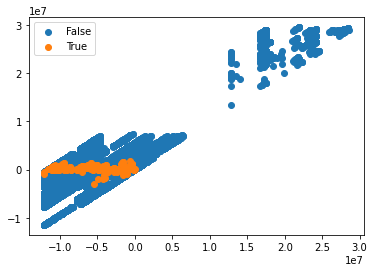

Counter({False: 5330, True: 2665})


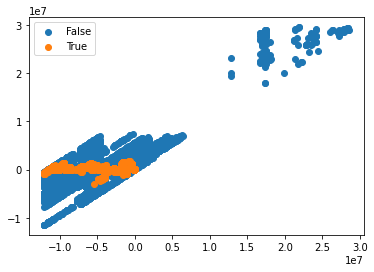

In [188]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Visualise class distribution before rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
modelsData_trainFeatures, modelsData_trainLabels = pipeline.fit_resample(modelsData_trainFeatures, modelsData_trainLabels)

#Visualise class distribution after rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

## 4.3 Modeling - Random Forest (OLD, only used for quick testing)

In [192]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 100 decision trees


# Train the model on training data

rf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier(n_estimators = 1000, n_jobs=-1))
])

rf.fit(modelsData_trainFeatures, modelsData_trainLabels.astype(bool));

#Display the model performance    
showModelPerformance(trainedModel = rf, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)


NameError: name 'SelectFromModel' is not defined

Elapsed time to compute the importances: 0.107 seconds


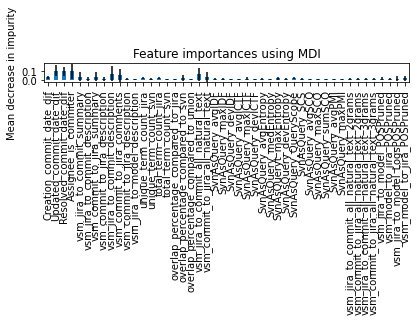

In [182]:
import time
import numpy as np

start_time = time.time()
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

import pandas as pd
import matplotlib.pyplot as plt
forest_importances = pd.Series(importances, index=processedData_dataProcessingFeatureNames)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 4.4 Modeling - XGBoost (OLD, only used for quick testing)

C:\Users\rande\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:13:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision   Recall        F1        F2      F0.5  \
0  0.986967   0.514706  0.76087  0.614035  0.694444  0.550314   

   Average Precision  
0           0.394882  

--------------------------------------------------------------------


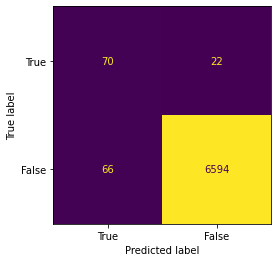

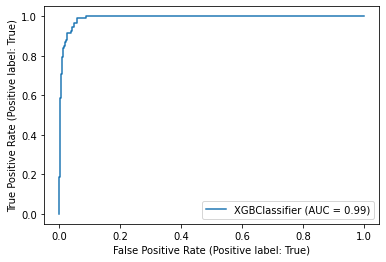

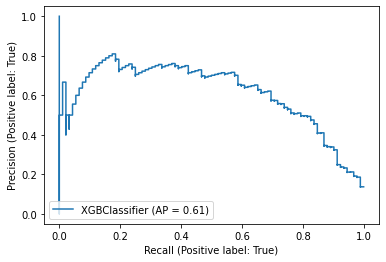

In [183]:
import xgboost as xgb

# Instantiate xgboost
GXBoost = xgb.XGBClassifier(#scale_pos_weight=1,
                            learning_rate=0.17,
                            colsample_bytree = 0.4,
                            subsample = 1.0,
                            objective='binary:logistic',
                            n_estimators=750,
                            max_depth=12,
                            gamma=0.03,
                            n_jobs=-1
                           # seed=27
)



# Train the model on training data
GXBoost.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = GXBoost, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

# Hyperparameter Tuning (OLD, only used for quick testing)

In [48]:
startTime = time.time()

# random search logistic regression model on the sonar dataset
from scipy.stats import loguniform
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# define model
model = xgb.XGBClassifier()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['n_estimators'] = [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
space['max_depth'] = [2, 3, 4, 5, 6, 7, 8, 9, 10]
space['subsample'] = [0.5, 0.6, 0.7, 0.8, 0.9]
space['gamma'] = [0.01, 0.02, 0.03, 0.04, 0.05]
space['colsample_bytree'] = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
space['learning_rate'] = [0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]


# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='precision', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(modelsData_trainFeatures, modelsData_trainLabels)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

timeDif = str(time.time() - startTime)
print("Finished after " + timeDif + " sec")

KeyboardInterrupt: 

In [ ]:
startTime = time.time()

# random search logistic regression model on the sonar dataset
from scipy.stats import loguniform
from pandas import read_csv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# define model
model = RandomForestClassifier(n_estimators = 500)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
# define search space
space = dict()
space['n_estimators'] = [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
space['max_depth'] = [2, 3, 4, 5, 6, 7, 8, 9, 10]
space['min_samples_split'] = [1, 2, 3]



# define search
search = RandomizedSearchCV(model, space, n_iter=100, scoring='precision', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(modelsData_trainFeatures, modelsData_trainLabels)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

timeDif = str(time.time() - startTime)
print("Finished after " + timeDif + " sec")

# Model - Pipeline for Random Forests

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


pipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy=1, n_jobs=-1)],
                                ['classifier', RandomForestClassifier(n_jobs=-1)]])

stratified_kfold = StratifiedKFold(n_splits=3,shuffle=True)

# define search space
space = dict() 
space['classifier__n_estimators'] = [1000, 1100, 1200, 1300, 1400]
space['classifier__max_depth'] = [9, 10, 11, 12, 14, 15, 16]
space['classifier__min_samples_split'] = [1, 2, 3]


search = RandomizedSearchCV(estimator = pipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring='precision', 
                            n_jobs=-1, 
                            cv = stratified_kfold)

optimizedRFModel = search.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedRFModel.best_score_
test_score = optimizedRFModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedRFModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedRFModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

# Model - Pipeline for GXBoost

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb


start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


GXBoostPipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy=0.1, n_jobs=-1)],
                                    ['under', RandomUnderSampler(sampling_strategy=0.5)],
                                ['classifier', xgb.XGBClassifier(n_jobs=-1)]])

stratified_kfold = StratifiedKFold(n_splits=3,shuffle=True)

# define search space
space = dict()
space['classifier__n_estimators'] = [450, 500, 550, 600, 650, 700, 750, 800, 850, 900]
space['classifier__max_depth'] = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
space['classifier__subsample'] = [0.7, 0.8, 0.9, 1.0]
space['classifier__learning_rate'] = [0.17, 0.18, 0.19, 0.2]
space['classifier__colsample_bytree'] = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
space['classifier__gamma'] = [0.01, 0.02, 0.03, 0.04, 0.05]

GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring='precision', 
                            n_jobs=-1, 
                            cv = stratified_kfold)

optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedGXBoostModel.best_score_
test_score = optimizedGXBoostModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedGXBoostModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

# Model Pipeline - Light GBM

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Import the model we are using
import lightgbm as lgb

# Instantiate Light GBM
LightGBM_Model = lgb.LGBMClassifier( n_jobs=-1, n_estimators = 500, max_depth = 9)                         

# Train the model on training data
LightGBM_Model.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = LightGBM_Model, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

# Model Pipeline - Catboost

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Import the model we are using
import catboost as cb

# Instantiate Light GBM
CatBoost_Model = cb.CatBoostClassifier()

# Train the model on training data
CatBoost_Model.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = CatBoost_Model, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)